In [1]:
from comparison_utils import *
from mpl_toolkits.mplot3d import Axes3D
import markers_utils
import stream2 as st2
import graph_loops
%load_ext rpy2.ipython

def load_slingshot(res_path,slingshot_ncenters):
    %R -i res_path -i slingshot_ncenters
    %R path <- slingshot_ncenters
    curves_gmm = %R readRDS(paste(res_path,'slingshot_curves_gmm.rds',sep='_'))
    curves_kmeans = %R readRDS(paste(res_path,'slingshot_curves_kmeans',path,'.rds',sep='_'))
    cl1 = %R readRDS(paste(res_path,'slingshot_gmm.rds',sep='_'))
    cl2 = %R readRDS(paste(res_path,'slingshot_kmeans',path,'.rds',sep='_'))
    
    all_lineages = {}
    for n,curve in zip(['kmeans','GMM'],[curves_kmeans,curves_gmm]):
        lineages = dict(curve.items())
        for k,v in lineages.items():
            lineages[k] = dict(v.items())
            for k2,v2 in lineages[k].items():
                lineages[k][k2]=np.array(lineages[k][k2])
            lineages[k]['s']=lineages[k]['s'][lineages[k]['ord']-1]
        all_lineages[n]=lineages

    all_lineages['kmeans'] = [v['s'] for k,v in all_lineages['kmeans'].items()]
    all_lineages['GMM'] = [v['s'] for k,v in all_lineages['GMM'].items()]
    return all_lineages

def load_monocle(res_path,mcle_ncenters ,mcle_sigma,mcle_gamma):
    %R -i res_path -i mcle_ncenters -i mcle_sigma -i mcle_gamma
    path = %R path <- paste(mcle_ncenters,mcle_sigma,mcle_gamma,sep='_')
    path=path[0]
    nodep = %R readRDS(paste(res_path,'monocle_dp_mst',path,'.rds',sep='_'))
    nodep = np.array(nodep.T)
    stree = scipy.io.mmread(res_path+f'_monocle_stree_{path}_.mm')
    edges = np.argwhere(np.triu(stree.todense()))
    clus = %R readRDS(paste(res_path,'monocle_clus',path,'.rds',sep='_'))
    partitions = np.array(np.array(clus)[1])
    clusters = np.array(np.array(clus)[2])
    return nodep, stree, edges, partitions, clusters

def run_monocle_slingshot_tuned(data_path, res_path, slingshot_ncenters = 50,mcle_ncenters = 50,mcle_sigma = 0.01,mcle_gamma = 0.5,mcle_eps = 1e-05):
    ! /home/jo/anaconda3/envs/qz_monocle3/bin/Rscript run_monocle_slingshot_tuned.R $data_path $slingshot_ncenters $mcle_ncenters $mcle_sigma $mcle_gamma $mcle_eps $res_path
    
    lineages = load_slingshot(res_path,slingshot_ncenters)
    nodep, stree, edges, partitions, clusters = load_monocle(res_path,mcle_ncenters ,mcle_sigma ,mcle_gamma)
    return lineages, nodep, stree, edges, partitions, clusters

def run_epg(_anndata,n_nodes, epg_lambda=0.02,epg_mu=0.1,epg_alpha=0.02):
    X=_anndata.obsm['X_dr']

    kde = KernelDensity(kernel='gaussian',bandwidth=.5).fit(X)
    scores = kde.score_samples(X)
    scores = np.exp(scores)[:,None]
    pointweights = 1/scores
    pointweights /= np.sum(pointweights)  
    
    st2.tl.seed_graph(_anndata,obsm='X_dr',n_clusters=10)
    st2.tl.learn_graph(_anndata,obsm='X_dr',n_nodes=n_nodes,epg_alpha=epg_alpha,epg_mu=epg_mu,epg_lambda=epg_lambda,#GPU=True,
                                                StoreGraphEvolution=True,PointWeights=pointweights,
                                                MaxNumberOfGraphCandidatesDict={'AddNode2Node': 20, 'BisectEdge': 10, 'ShrinkEdge':np.inf},
                                                #new kwargs
                                                #epg_pseudotime=np.array(_anndata.X[:,0]+_anndata.X[:,1]),
                                                #epg_pseudotimeLambda=0.005,
                                                #epg_FixNodesAtPoints=[[1681]],#[[110]],#[[2445]],
                                                verbose=1,
                                                use_seed=True
                                               )
    #st2.tl.infer_pseudotime(_anndata,source=0)
    epg_nodep=_anndata.uns['epg']['node_pos']
    epg_edges=_anndata.uns['epg']['edge']

    return epg_nodep, epg_edges, pointweights

def get_cycle_pseudotime(adata,merged_nodep,merged_edges,key='epg',cycle_idx=0):
    
    if adata.uns[key]["params"]["obsm"] is not None:
        mat = adata.obsm[adata.uns[key]["params"]["obsm"]]
    elif adata.uns[key]["params"]["layer"] is not None:
        mat = adata.obsm[adata.uns[key]["params"]["layer"]]
    else:
        mat = adata.X

    adata.uns[key]['node_pos'] = merged_nodep
    adata.uns[key]['edge'] = merged_edges
    st2.tl._elpigraph._store_graph_attributes(_anndata,mat,key)

    G = nx.Graph(merged_edges.tolist())
    cycle_nodes = graph_loops.find_all_cycles(G)[cycle_idx]
    
    d=np.array([G.degree[e] for e in cycle_nodes])
    branching_node = np.array(cycle_nodes)[d>2][0]
    branching_node_idx = cycle_nodes.index(branching_node)
    branching_node_cycle_nn = np.array(cycle_nodes)[[branching_node_idx-1,branching_node_idx+1]]

    st2.tl.infer_pseudotime(adata,source=branching_node,target=branching_node_cycle_nn[1],
                            nodes_to_include=[branching_node_cycle_nn[0]])
    st2.pl.graph(adata,color=['epg_pseudotime'],show_text=True,fig_size=(6,6),fontsize=20,alpha=0.4,size=5)
    
def get_tp(gene_list,vars_bool):
    tp_score = []
    perc_detected = []
    print(vars_bool.shape)
    for i,n in enumerate(vars_bool.index):
        print(i,end='\r')
        if n in gene_list:
            vars_bool[n] = True
        perc_detected.append(sum(vars_bool[:n])/len(gene_list))
        tp_score.append(sum(vars_bool[:n])/(i+1))
    return perc_detected, tp_score

# Data

In [152]:
data_path = '/mnt/c/Users/jobac/Desktop/all/STREAM2/data/pdx352_nufp2k.csv'
X = np.loadtxt(data_path,delimiter=',').T
X_full = pd.read_csv('/mnt/c/Users/jobac/Desktop/all/STREAM2/data/ewing/pdx352_nufp.txt',sep='\t').T
X_ica = pd.read_csv('/mnt/c/Users/jobac/Desktop/all/STREAM2/data/ewing/moduleAverages/pdx352_nufp2k.txt.moduleAverages',sep='\t').iloc[:,1:21]

X_full.rename(columns=X_full.iloc[0],inplace=True)
X_full.drop(X_full.index[0],inplace=True)
X_full.drop(columns=np.nan,axis=1,inplace=True)
ccycle = np.diag(X[:,:2] @ X[:,:2].T)#**(1/32)
c=ccycle = (ccycle - ccycle.min())/(ccycle.max() - ccycle.min())

_anndata=sc.AnnData(X_full)
sc.pp.highly_variable_genes(_anndata,n_top_genes=2000,subset=True)
sc.pp.pca(_anndata)
_anndata.obsm['X_dr']=X
_anndata.obsm['X_ica']=X_ica.values

In [5]:
data_path = '/mnt/c/Users/jobac/Desktop/all/STREAM2/data/pdx352_nufp2k.csv'
X = np.loadtxt(data_path,delimiter=',')

# Default trajectories


Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")

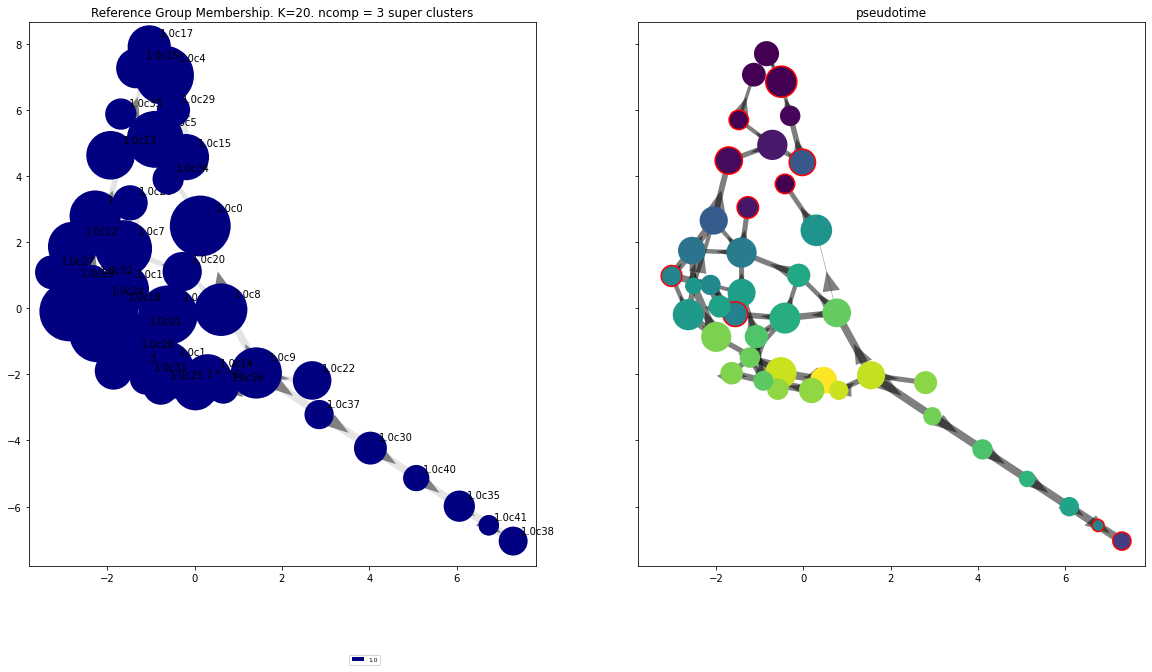

time elapsed 59.9 seconds
input data has shape 3595 (samples) x 3 (features)
time is Thu Oct 28 11:03:02 2021
commencing global pruning
Share of edges kept after Global Pruning 49.83 %
commencing community detection
time is Thu Oct 28 11:03:02 2021
49  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global pruning relative to start 54.1
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times
ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [33, 34, 4, 38, 41, 13, 15, 18, 26, 27]
no sub cluster has majority made of super-cluster  15
terminal clus in this component [33, 18, 9, 36, 42, 1, 26, 17, 38, 43]
final terminal clus [33, 18, 9, 36, 42, 1, 26, 17, 38, 43]
From root 13  to Terminal state 33 is found

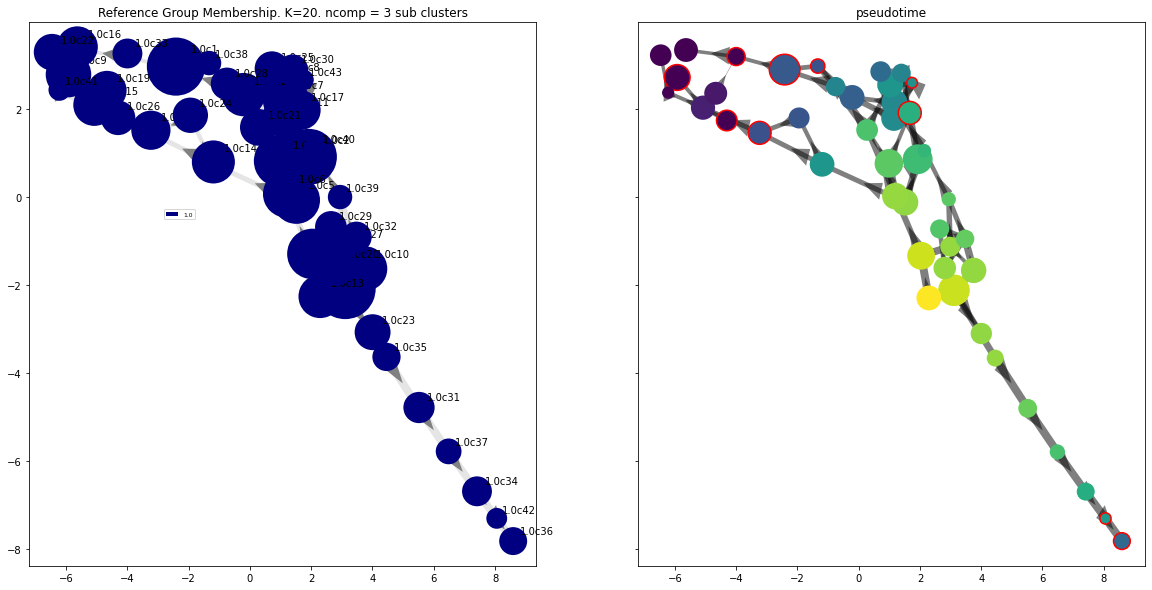

time elapsed 63.4 seconds
dict of terminal state pairs, Super: sub:  {33: 33, 34: 18, 4: 9, 38: 36, 41: 42, 13: 1, 15: 26, 18: 17, 26: 38, 27: 43}


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 33
super cluster 13 is a super terminal with sub_terminal cluster 18
super cluster 15 is a super terminal with sub_terminal cluster 9
super cluster 18 is a super terminal with sub_terminal cluster 36
super cluster 26 is a super terminal with sub_terminal cluster 42
super cluster 27 is a super terminal with sub_terminal cluster 1
super cluster 33 is a super terminal with sub_terminal cluster 26
super cluster 34 is a super terminal with sub_terminal cluster 17
super cluster 38 is a super terminal with sub_terminal cluster 38
super cluster 41 is a super terminal with sub_terminal cluster 43


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 33
super cluster 13 is a super terminal with sub_terminal cluster 18
super cluster 15 is a super terminal with sub_terminal cluster 9
super cluster 18 is a super terminal with sub_terminal cluster 36
super cluster 26 is a super terminal with sub_terminal cluster 42
super cluster 27 is a super terminal with sub_terminal cluster 1
super cluster 33 is a super terminal with sub_terminal cluster 26
super cluster 34 is a super terminal with sub_terminal cluster 17
super cluster 38 is a super terminal with sub_terminal cluster 38
super cluster 41 is a super terminal with sub_terminal cluster 43


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 33
super cluster 13 is a super terminal with sub_terminal cluster 18
super cluster 15 is a super terminal with sub_terminal cluster 9
super cluster 18 is a super terminal with sub_terminal cluster 36
super cluster 26 is a super terminal with sub_terminal cluster 42
super cluster 27 is a super terminal with sub_terminal cluster 1
super cluster 33 is a super terminal with sub_terminal cluster 26
super cluster 34 is a super terminal with sub_terminal cluster 17
super cluster 38 is a super terminal with sub_terminal cluster 38
super cluster 41 is a super terminal with sub_terminal cluster 43
input data has shape 3595 (samples) x 20 (features)
time is Thu Oct 28 11:08:32 2021
commencing global pruning
Share of edges kept after Global Pruning 46.36 %
number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 
size neighbor array in low-KNN in pca-space for visua

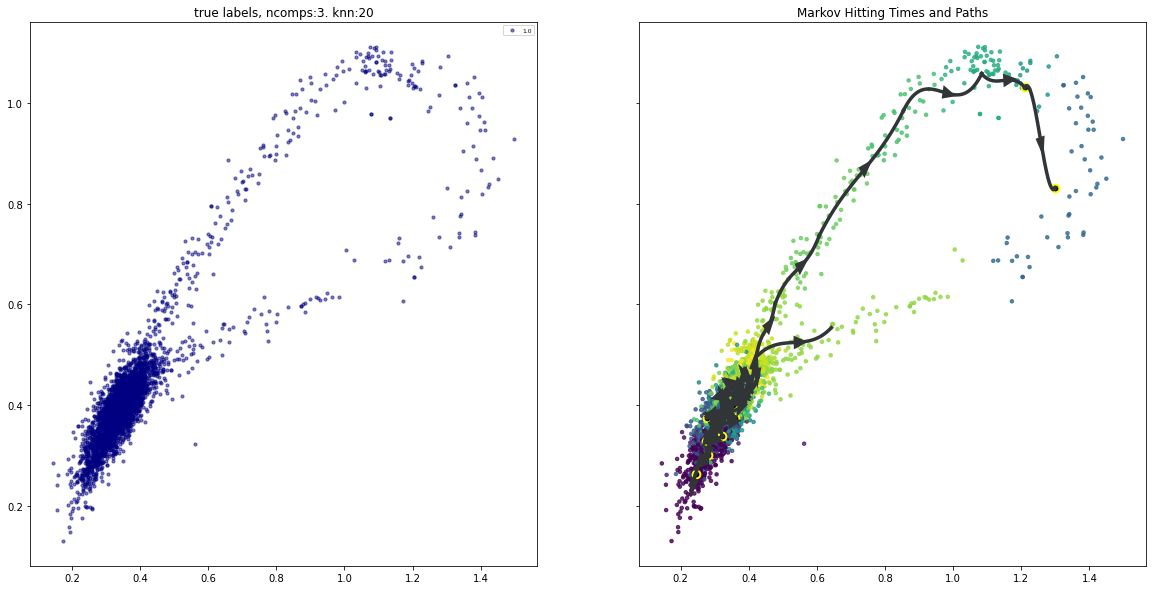

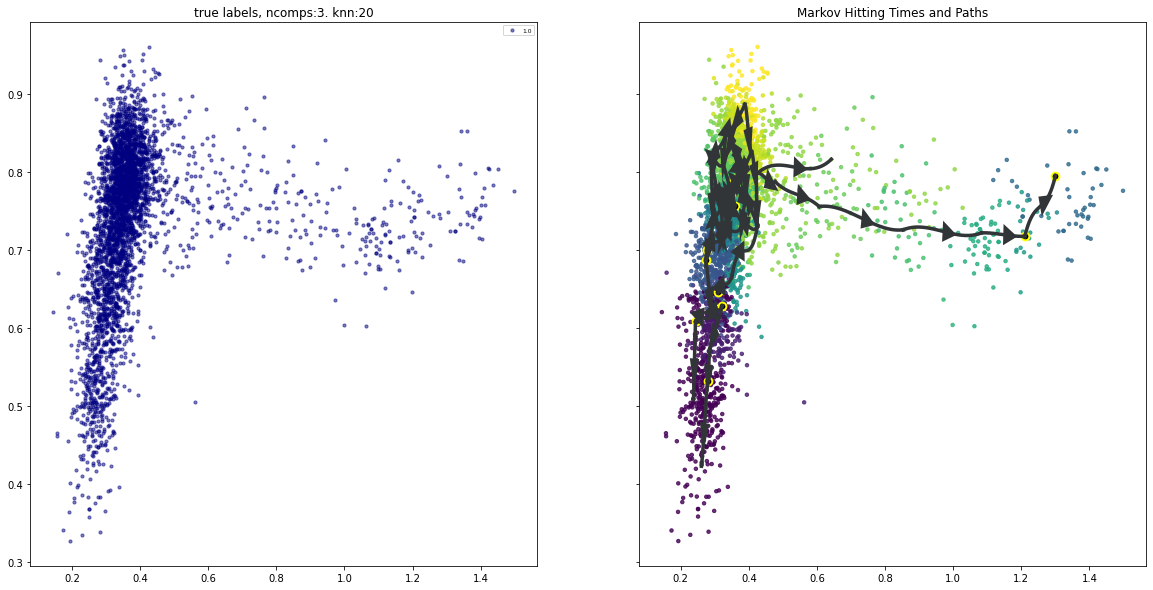

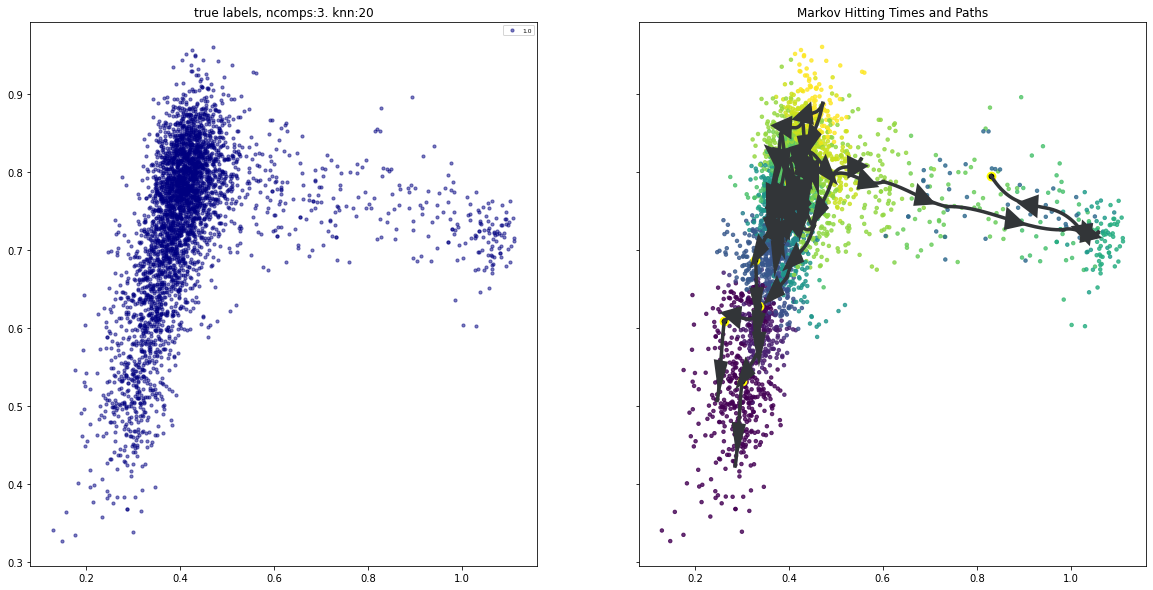

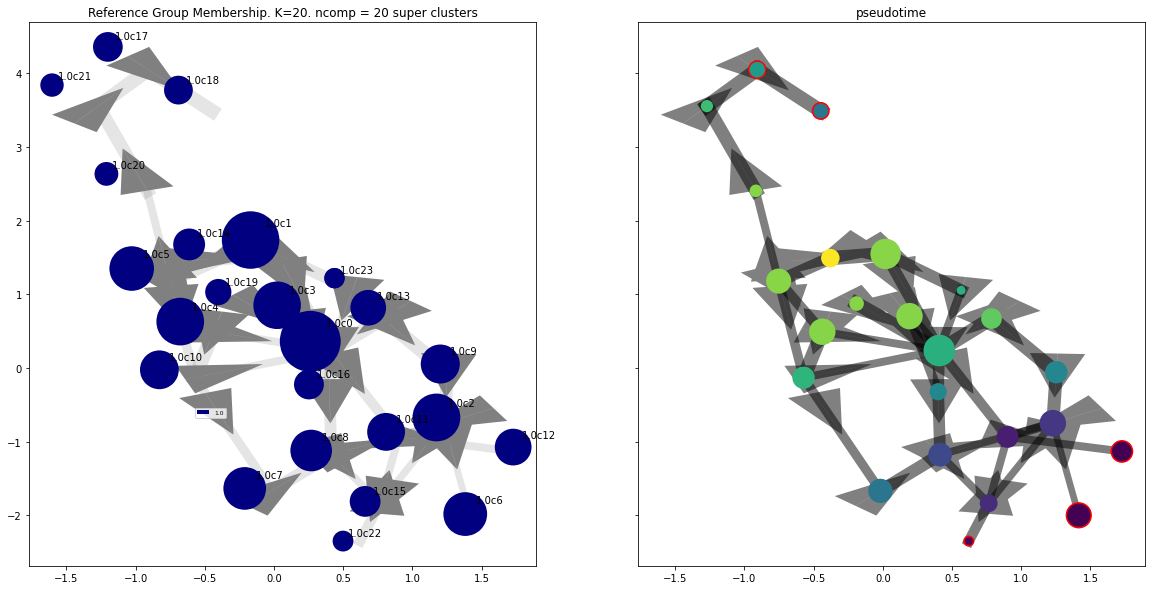

time elapsed 42.2 seconds
input data has shape 3595 (samples) x 20 (features)
time is Thu Oct 28 11:09:12 2021
commencing global pruning
Share of edges kept after Global Pruning 49.98 %
commencing community detection
time is Thu Oct 28 11:09:12 2021
48  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global pruning relative to start 55.3
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times
ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [6, 12, 17, 18, 22]
terminal clus in this component [7, 13, 15, 17, 22]
final terminal clus [7, 13, 15, 17, 22]
From root 0  to Terminal state 7 is found 369  times.
From root 0  to Terminal state 13 is found 73  times.
From root 0  to Terminal state 15 is found 174

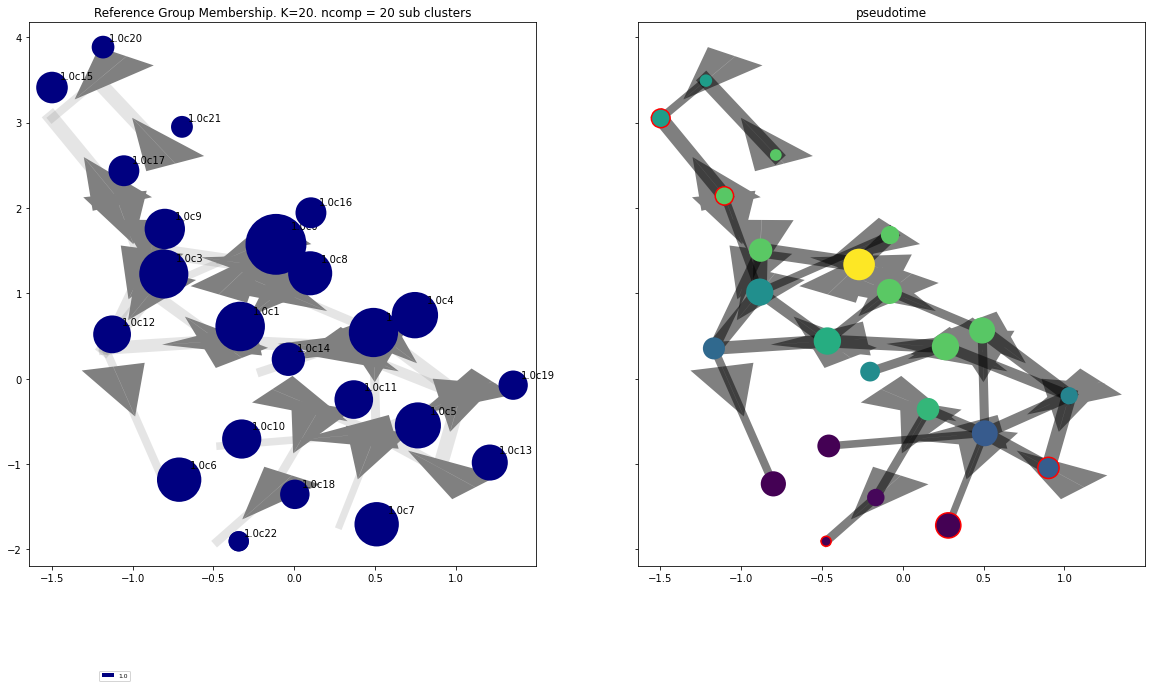

time elapsed 26.0 seconds
dict of terminal state pairs, Super: sub:  {6: 7, 12: 13, 17: 15, 18: 17, 22: 22}


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 6 is a super terminal with sub_terminal cluster 7
super cluster 12 is a super terminal with sub_terminal cluster 13
super cluster 17 is a super terminal with sub_terminal cluster 15
super cluster 18 is a super terminal with sub_terminal cluster 17
super cluster 22 is a super terminal with sub_terminal cluster 22


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 6 is a super terminal with sub_terminal cluster 7
super cluster 12 is a super terminal with sub_terminal cluster 13
super cluster 17 is a super terminal with sub_terminal cluster 15
super cluster 18 is a super terminal with sub_terminal cluster 17
super cluster 22 is a super terminal with sub_terminal cluster 22


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 6 is a super terminal with sub_terminal cluster 7
super cluster 12 is a super terminal with sub_terminal cluster 13
super cluster 17 is a super terminal with sub_terminal cluster 15
super cluster 18 is a super terminal with sub_terminal cluster 17
super cluster 22 is a super terminal with sub_terminal cluster 22
input data has shape 3595 (samples) x 20 (features)
time is Thu Oct 28 11:12:15 2021
commencing global pruning
Share of edges kept after Global Pruning 47.03 %
number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 
size neighbor array in low-KNN in pca-space for visualization (3595, 6)
commencing community detection
time is Thu Oct 28 11:12:23 2021
125  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.7
percentage l

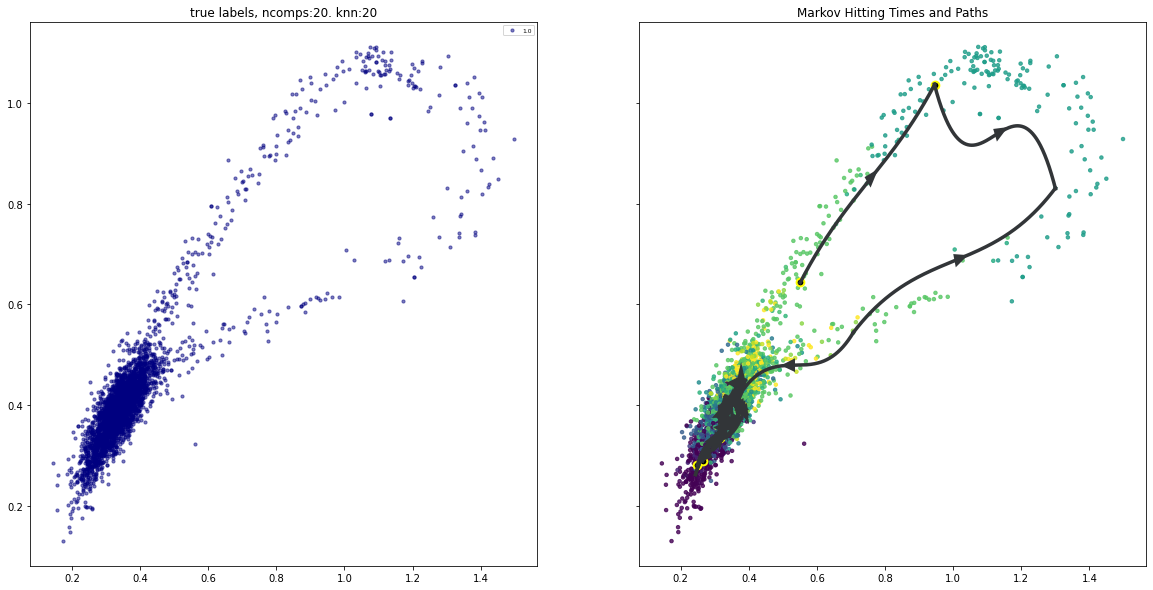

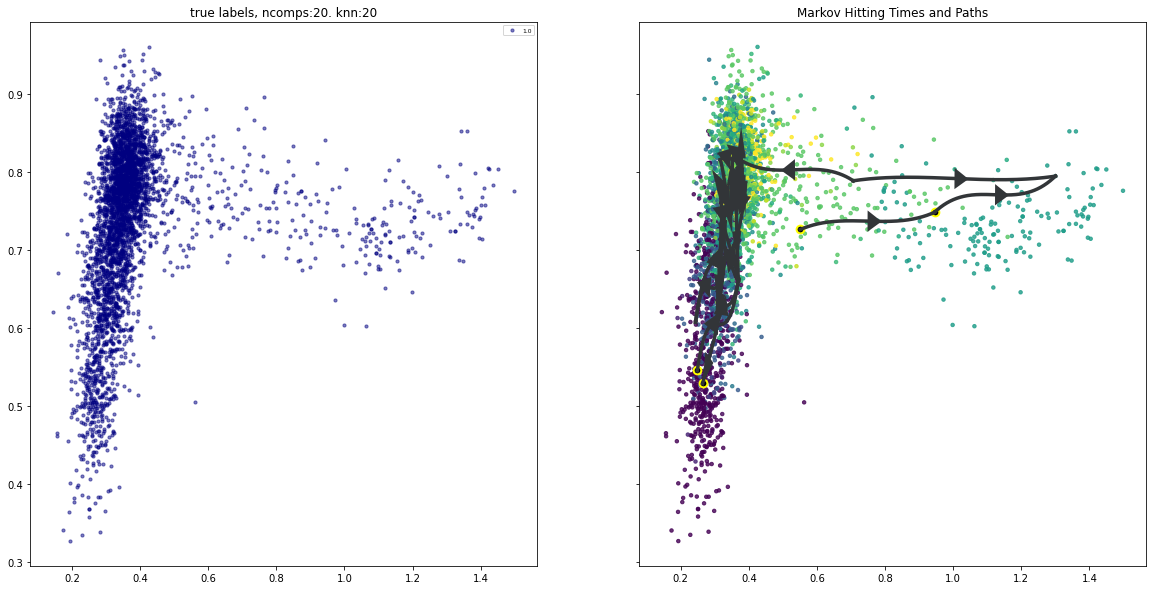

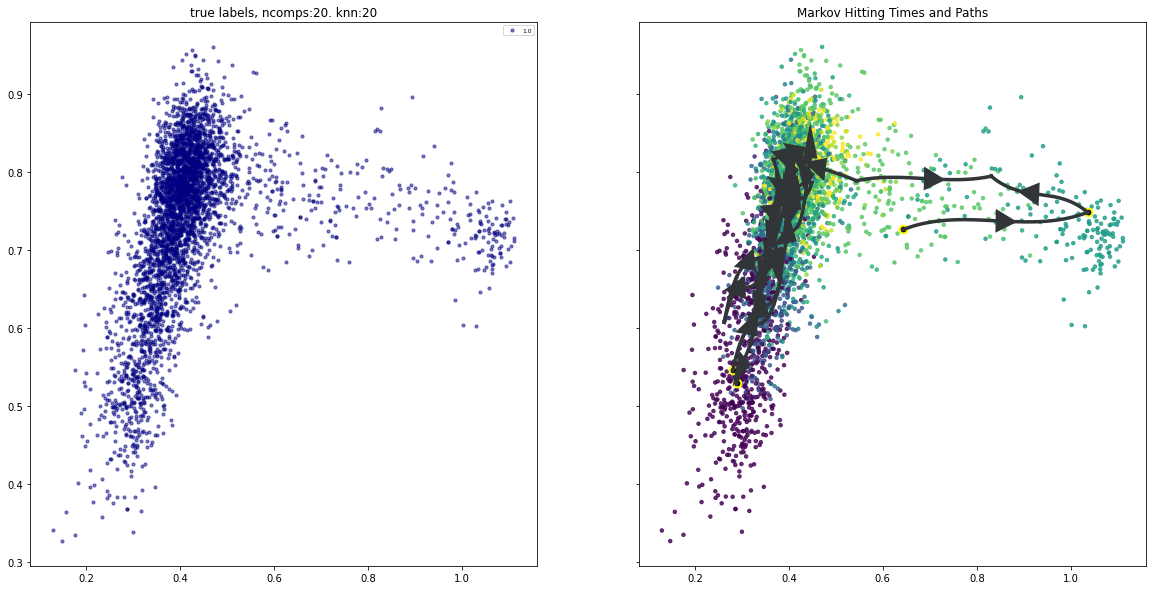

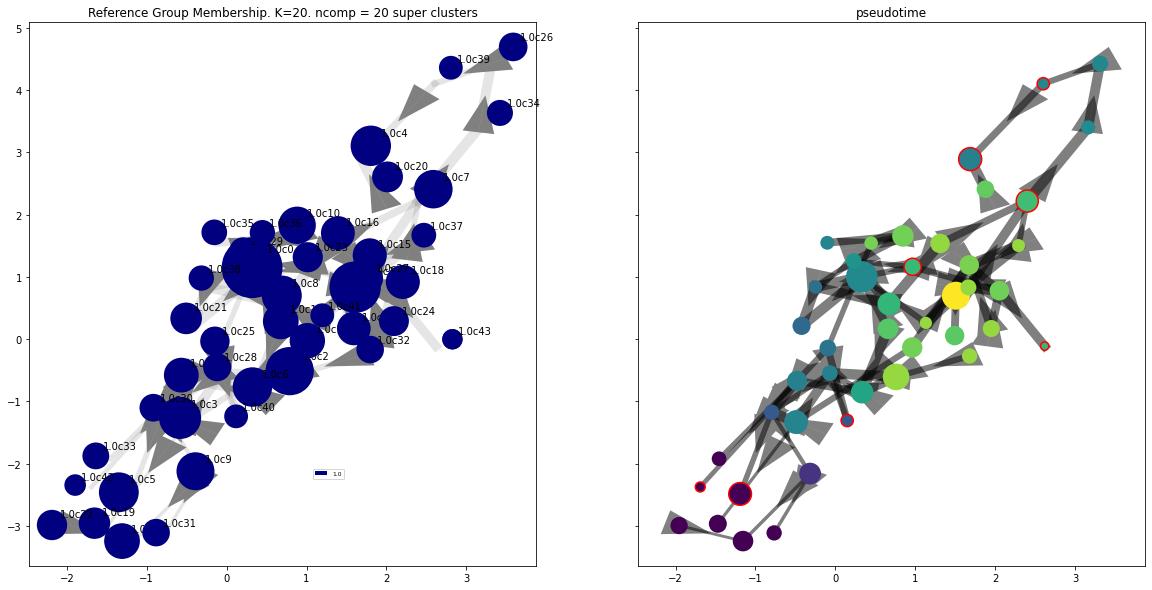

time elapsed 143.4 seconds
input data has shape 3595 (samples) x 20 (features)
time is Thu Oct 28 11:14:35 2021
commencing global pruning
Share of edges kept after Global Pruning 49.93 %
commencing community detection
time is Thu Oct 28 11:14:35 2021
104  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.1
percentage links trimmed from global pruning relative to start 60.1
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times
ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [4, 5, 7, 23, 39, 40, 42, 43]
the sub terminal cluster that best captures the super terminal 23 is 22 but the pseudotime is too low
no sub cluster has majority made of super-cluster  40
no sub cluster has majority made of super-cluster  42
terminal clus in this co

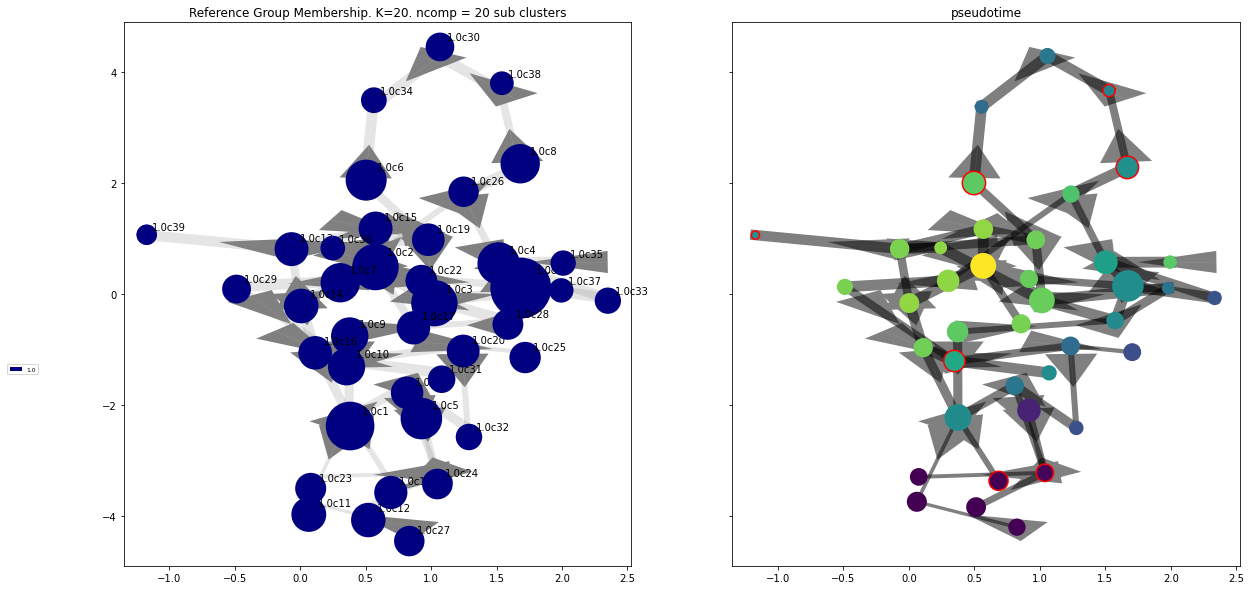

time elapsed 122.4 seconds
dict of terminal state pairs, Super: sub:  {4: 8, 5: 18, 7: 6, 39: 38, 40: 10, 42: 24, 43: 39}


100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 8
super cluster 5 is a super terminal with sub_terminal cluster 18
super cluster 7 is a super terminal with sub_terminal cluster 6
super cluster 39 is a super terminal with sub_terminal cluster 38
super cluster 40 is a super terminal with sub_terminal cluster 10
super cluster 42 is a super terminal with sub_terminal cluster 24
super cluster 43 is a super terminal with sub_terminal cluster 39


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 8
super cluster 5 is a super terminal with sub_terminal cluster 18
super cluster 7 is a super terminal with sub_terminal cluster 6
super cluster 39 is a super terminal with sub_terminal cluster 38
super cluster 40 is a super terminal with sub_terminal cluster 10
super cluster 42 is a super terminal with sub_terminal cluster 24
super cluster 43 is a super terminal with sub_terminal cluster 39


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 8
super cluster 5 is a super terminal with sub_terminal cluster 18
super cluster 7 is a super terminal with sub_terminal cluster 6
super cluster 39 is a super terminal with sub_terminal cluster 38
super cluster 40 is a super terminal with sub_terminal cluster 10
super cluster 42 is a super terminal with sub_terminal cluster 24
super cluster 43 is a super terminal with sub_terminal cluster 39


TypeError: run_epg() got an unexpected keyword argument 'incr_n_nodes'

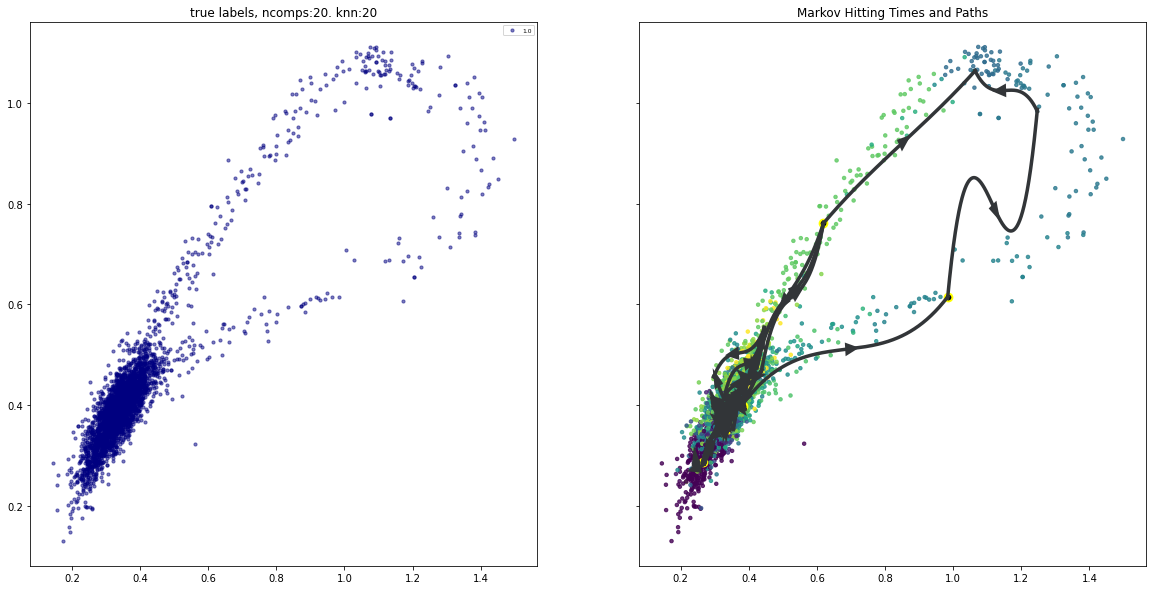

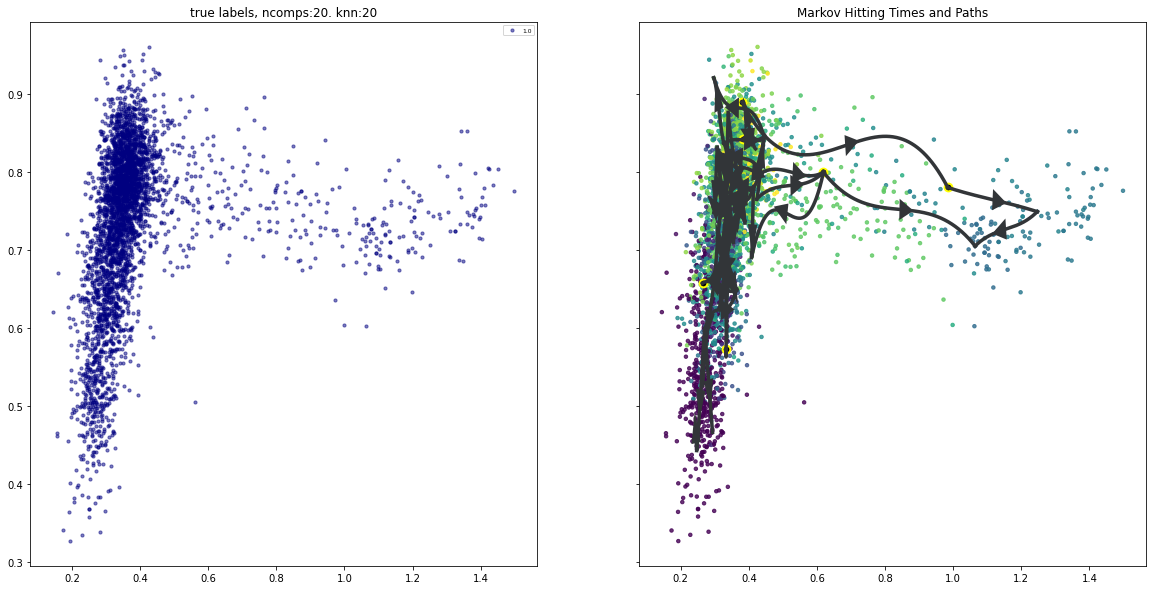

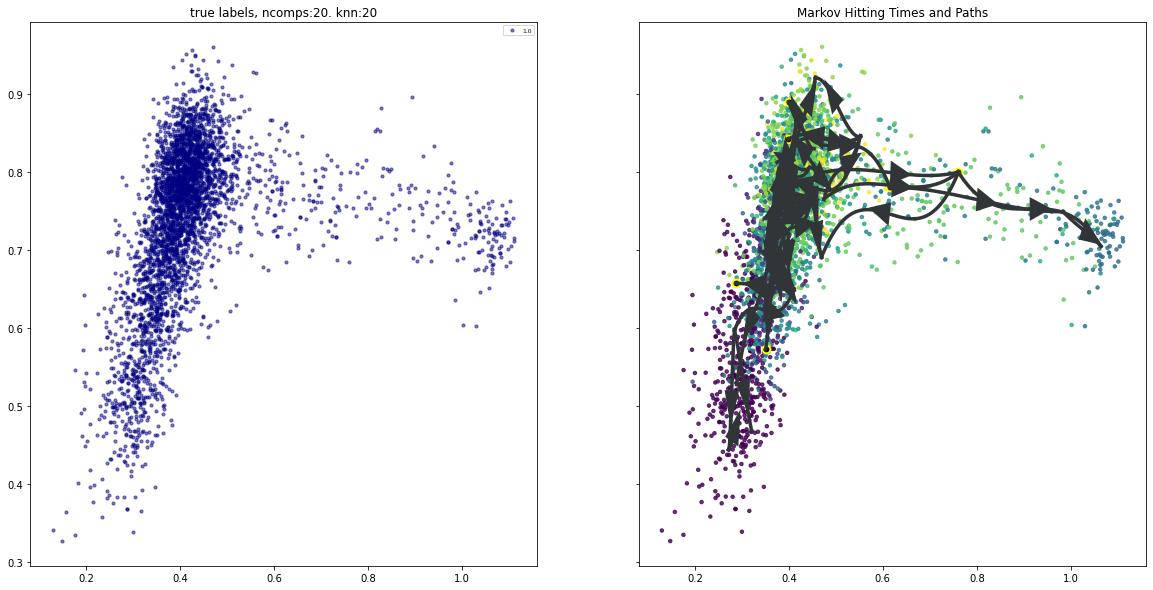

In [3]:
#default results
(slingshot_lineages, 
 mcle_nodep, mcle_stree, mcle_edges, 
 mcle_partitions, mcle_clusters) = run_monocle_slingshot_tuned(data_path, slingshot_ncenters = 50, 
                                                         mcle_ncenters = 50, mcle_sigma = 0.01, 
                                                         mcle_gamma = 0.5, mcle_eps = 1e-05,res_path='R_outputs/ewing/')

((via_out, via_projected_sc_pt, 
 (loci, c_edge, width_edge, pen_color, dot_size)),
 (via_out2, via_projected_sc_pt2,
 (loci2, c_edge2, width_edge2, pen_color2, dot_size2)),
 (via_out3, via_projected_sc_pt3,
 (loci3, c_edge3, width_edge3, pen_color3, dot_size3)),) = run_VIA(X,X,labels=None,root_user = [0], 
                                                            v0_too_big = 0.4 , v1_too_big = 0.1, v0_random_seed = 42, 
                                                            knn = 20,ncomps=3)

((via_out_ica, via_projected_sc_pt_ica, 
 (loci_ica, c_edge_ica, width_edge_ica, pen_color_ica, dot_size_ica)),
 (via_out2_ica, via_projected_sc_pt2_ica,
 (loci2_ica, c_edge2_ica, width_edge2_pca, pen_color2_ica, dot_size2_ica)),
 (via_out3_ica, via_projected_sc_pt3_ica,
 (loci3_ica, c_edge3_ica, width_edge3_ica, pen_color3_ica, dot_size3_ica)),) = run_VIA(_anndata.obsm['X_ica'],X,labels=None,root_user = [0], 
                                                            v0_too_big = 0.3 , v1_too_big = 0.1, v0_random_seed = 42, 
                                                            knn = 20,ncomps=20)

((via_out_pca, via_projected_sc_pt_pca, 
 (loci_pca, c_edge_pca, width_edge_pca, pen_color_pca, dot_size_pca)),
 (via_out2_pca, via_projected_sc_pt2_pca,
 (loci2_pca, c_edge2_pca, width_edge2_pca, pen_color2_pca, dot_size2_pca)),
 (via_out3_pca, via_projected_sc_pt3_pca,
 (loci3_pca, c_edge3_pca, width_edge3_pca, pen_color3_pca, dot_size3_pca)),) = run_VIA(_anndata.obsm['X_pca'],X,labels=None,root_user = [0], 
                                                            v0_too_big = 0.3 , v1_too_big = 0.1, v0_random_seed = 42, 
                                                            knn = 20,ncomps=20)

paga_nodep, paga_edges, paga_weights = run_paga(_anndata,X,resolution=1)
epg_nodep, epg_edges, epg_pointweights = run_epg(_anndata, incr_n_nodes=30,epg_alpha=0)
#_, _, _, merged_nodep, merged_edges = graph_loops.add_loops(X,epg_nodep,epg_edges,_anndata.uns['epg'],
#                                                            min_path_len=len(epg_nodep)//3, nnodes=6,
#                                                            max_inner_fraction=.005,min_node_n_points=5,max_n_points=np.inf,
#                                                            radius=1,plot=True,Lambda=.02,Mu=.1,weights=epg_pointweights
#                                                            )

_, _, _, merged_nodep, merged_edges = graph_loops.add_loops(X,epg_nodep,epg_edges,
                                                            nx.convert_matrix.from_scipy_sparse_matrix(_anndata.uns['epg']['conn']),
                                                            min_path_len=None,
                                                            nnodes=6,
                                                            max_inner_fraction=0.05,
                                                            min_node_n_points=5,
                                                            max_n_points=np.inf,
                                                            max_empty_curve_fraction=None,
                                                            radius=None,
                                                            allow_same_branch=True,
                                                            fit_loops=True,
                                                            Lambda=0.02,
                                                            Mu=0.1,
                                                            plot=False,
                                                            verbose=False,
                                                            weights=epg_pointweights )

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
Constructing tree 1 of 1 / Subset 1 of 1
Computing EPG with  50  nodes on  3595  points and  3  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||11	0.0116	11	10	9	0	0	0	0.0058	0.0049	0.911	0.9251	0.004	0.0018	0.0199	0.2186	0
0||12	0.0109	12	11	10	0	0	0	0.0057	0.0048	0.913	0.9263	0.0036	0.0016	0.0194	0.2329	0
0||13	0.0104	13	12	11	0	0	0	0.0055	0.0047	0.9155	0.9279	0.0034	0.0015	0.019	0.2473	0
0||14	0.0098	14	13	12	0	0	0	0.005	0.0045	0.9234	0.9316	0.0035	0.0013	0.0182	0.2546	0
0||15	0.0093	15	14	13	0	0	0	0.0049	0.0043	0.9254	0.9337	0.0032	0.0012	0.0183	0.2739	0
0||16	0.0089	16	15	14	0	0	0	0.0048	0.0042	0.927	0.9355	0.0031	0.0011	0.0168	0.2692	0
0||17	0.0085	17	16	15	0	0	0	0.0045	0.004	0.9313	0.9383	0.0032	0.0008	0.0144	0.245	0
0||18	0.0082	18	17	16	0	0	0	0.0044	0.0039	0.9331	0.9399	0.003	0.0008	0.0147	0.2648	0
0||

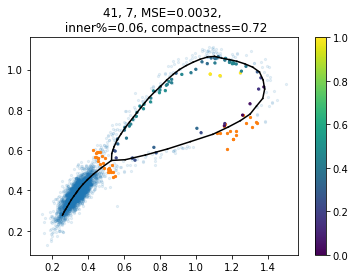

In [153]:
epg_nodep, epg_edges, epg_pointweights = run_epg(_anndata, 50,epg_alpha=0)
_, _, _, merged_nodep, merged_edges = graph_loops.add_loops(X,epg_nodep,epg_edges,
                                                            nx.convert_matrix.from_scipy_sparse_matrix(_anndata.uns['epg']['conn']),
                                                            min_path_len=None,
                                                            nnodes=None,
                                                            max_inner_fraction=.1,
                                                            min_node_n_points=1,
                                                            max_n_points=np.inf,
                                                            min_compactness=.2,
                                                            radius=None,
                                                            allow_same_branch=True,
                                                            fit_loops=True,
                                                            Lambda=0.02,
                                                            Mu=0.1,
                                                            plot=True,
                                                            verbose=True,
                                                            weights=epg_pointweights)

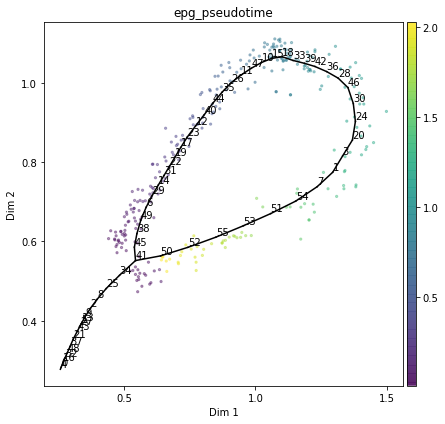

In [156]:
get_cycle_pseudotime(_anndata,merged_nodep,merged_edges)

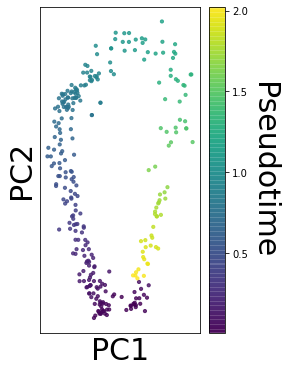

In [291]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

G = nx.Graph(merged_edges.tolist())
cycle_nodes = graph_loops.find_all_cycles(G)[0]
d=np.array([G.degree[e] for e in cycle_nodes])
branching_node = np.array(cycle_nodes)[d>2][0]
branching_node_idx = cycle_nodes.index(branching_node)

cycle_merged_edges = merged_edges[np.isin(merged_edges[:,0],cycle_nodes) & np.isin(merged_edges[:,1],cycle_nodes)]
cycle_nodep = merged_nodep[cycle_nodes] 
cycle_edges_array = np.append(np.array(list(zip(range(len(cycle_nodes)-1),
                                                range(1,len(cycle_nodes))))),[[len(cycle_nodes)-1,0]],axis=0)  

_adata=_anndata[np.isfinite(_anndata.obs['epg_pseudotime'])].copy()
pca = sklearn.decomposition.PCA(2).fit(_adata.obsm['X_dr'])
Xpca = pca.transform(_adata.obsm['X_dr'])
#merged_nodep_pca = pca.transform(merged_nodep)

plt.figure(figsize=(8,6))
ax_i = plt.subplot()

#for e in cycle_merged_edges:
#    curve_i = np.concatenate((merged_nodep_pca[[e[0]]], merged_nodep_pca[[e[1]]]),axis=0).T
#    ax_i.plot(curve_i[1], curve_i[0], c='k',linewidth=1)
_=ax_i.scatter(Xpca[:,1],Xpca[:,0],s=10,alpha=.8,c=_adata.obs['epg_pseudotime'])
   
ax_i.axis('scaled')
ax_i.set_xlabel("PC1",fontsize=30)
ax_i.set_ylabel("PC2",fontsize=30)
ax_i.set_xticks([])
ax_i.set_yticks([])
ax_i.locator_params(axis="x", nbins=5)
ax_i.locator_params(axis="y", nbins=5)
ax_i.tick_params(axis="both", labelbottom=True, labelleft=True)
cbar = plt.colorbar(_, ax=ax_i,fraction=0.046, pad=0.02)
#cbar.solids.set_edgecolor("face")
cbar.ax.locator_params(nbins=5)
cbar.set_label('Pseudotime', rotation=270,fontsize=30,labelpad=30)
plt.savefig("figures/ewing_cycle_scatter.png",dpi=300,bbox_inches='tight')

In [155]:
def plot_tp(fname,gene_list,vars_bools):
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    plt.rcParams.update({'font.size': 15})
    
    
    fig, axs = plt.subplots(3,1,figsize=(5,10),sharex=True,constrained_layout=True)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for i in range(3):
        ax1 = axs[i]
        perc_detected, tp_score = get_tp(gene_list,vars_bools[i])

        ax1.plot(perc_detected,label='Fraction of found markers',c=colors[1])
        ylim=ax1.get_ylim()
        ax1.plot(tp_score,label='True positives / Total tested',c=colors[0])

        ax1.set_ylim(ylim)

        ax2 = ax1.twinx()
        ax2.plot(np.array(perc_detected)*len(gene_list),alpha=0,c=colors[0])

        if i==0: ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4))
        if i==2: ax1.set_xlabel('Markers rank',fontsize=20)
            
        ax2.set_ylabel('Number',fontsize=20,rotation=270,labelpad=20)
        ax1.set_ylabel('Fraction',fontsize=20)
        ax1.xaxis.set_minor_locator(MultipleLocator(100))

    # Shrink current axis by 20%
    #box = ax1.get_position()
    #ax1.set_position([box.x0, box.y0, box.width, box.height * .9])
    plt.tight_layout()
    plt.savefig(fname,dpi=300,bbox_inches="tight")
    #plt.show()

In [20]:
up_varnames=_anndata.var_names.map(lambda s:s.upper())
cc_genes = ['ACYP1', 'ALG6', 'ANKRD32', 'ANLN', 'ANP32E', 'APEX2', 'APOBEC3B','ARHGAP11A', 'ARHGAP11B', 'ARHGAP19', 'ARHGEF39', 'ARL6IP1','ARL6IP6', 'ASF1B', 'ASPM', 'ATAD2', 'ATAD5', 'AURKA', 'AURKB','BARD1', 'BIRC5', 'BLM', 'BORA', 'BRCA1', 'BRCA2', 'BRD8', 'BRIP1','BUB1', 'BUB1B', 'BUB3', 'C11orf82', 'C15orf23', 'C18orf54','C19orf48', 'C1orf112', 'C20orf72', 'C3orf14', 'C4orf21','C4orf46', 'CASC5', 'CASP2', 'CASP8AP2', 'CCDC14', 'CCDC15','CCDC150', 'CCDC18', 'CCDC34', 'CCDC77', 'CCNA2', 'CCNB1', 'CCNB2','CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CCNE2', 'CCNF', 'CCNH','CCP110', 'CDC20', 'CDC25A', 'CDC25B', 'CDC25C', 'CDC45', 'CDC6','CDC7', 'CDCA2', 'CDCA3', 'CDCA4', 'CDCA5', 'CDCA7', 'CDCA7L','CDCA8', 'CDK1', 'CDK2', 'CDK4', 'CDK5RAP2', 'CDK6', 'CDK7','CDKN1A', 'CDKN1B', 'CDKN1C', 'CDKN2A', 'CDKN2B', 'CDKN2C','CDKN2D', 'CDKN3', 'CENPA', 'CENPE', 'CENPF', 'CENPI', 'CENPJ','CENPK', 'CENPL', 'CENPM', 'CENPN', 'CENPO', 'CENPQ', 'CEP128','CEP152', 'CEP44', 'CEP55', 'CEP70', 'CEP78', 'CHAC2', 'CHAF1A','CHAF1B', 'CHEK1', 'CIT', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B','CKS2', 'CLSPN', 'CNTRL', 'CSE1L', 'CSRP2', 'CTD-2510F5.4','CTDSPL2', 'CTPS1', 'DARS2', 'DAXX', 'DBF4', 'DCK', 'DCLRE1B','DCP2', 'DCTPP1', 'DDB2', 'DDX11', 'DDX12P', 'DDX39A', 'DEK','DEPDC1', 'DEPDC1B', 'DERA', 'DHCR24', 'DHFR', 'DIAPH3', 'DLGAP5','DNA2', 'DNAJC9', 'DNMT1', 'DONSON', 'DSN1', 'DTL', 'DTYMK', 'DUT','E2F1', 'E2F2', 'E2F4', 'E2F5', 'E2F7', 'ECT2', 'EED', 'EMC9','EME1', 'ENOSF1', 'ERCC6L', 'ERLIN1', 'ESCO2', 'ESPL1', 'EXO1','EXOSC8', 'EXOSC9', 'EZH2', 'FAM111A', 'FAM111B', 'FAM122B','FAM161A', 'FAM178A', 'FAM54A', 'FAM64A', 'FAM72D', 'FAM83D','FANCA', 'FANCB', 'FANCD2', 'FANCI', 'FANCL', 'FBXO4', 'FBXO5','FEN1', 'FGFR1OP', 'FIGNL1', 'FKBP5', 'FN3KRP', 'FOXM1', 'FOXRED2','G2E3', 'GAS2L3', 'GEN1', 'GGCT', 'GGH', 'GINS1', 'GINS2', 'GINS3','GINS4', 'GJC1', 'GMNN', 'GOT1', 'GPSM2', 'GTSE1', 'H2AFV','H2AFX', 'H2AFZ', 'HADH', 'HAT1', 'HAUS1', 'HAUS5', 'HAUS6','HAUS8', 'HELLS', 'HIRIP3', 'HIST1H1B', 'HIST1H4C', 'HJURP','HMGB2', 'HMGB3', 'HMGN2', 'HMGXB4', 'HMMR', 'HNRNPF', 'HPRT1','HSD17B11', 'HSPB11', 'INCENP', 'INSR', 'IQGAP3', 'ITGB3BP','IVNS1ABP', 'KDELC2', 'KIAA0101', 'KIAA0586', 'KIAA1524','KIAA1731', 'KIF11', 'KIF14', 'KIF15', 'KIF18A', 'KIF18B','KIF20A', 'KIF20B', 'KIF22', 'KIF23', 'KIF2C', 'KIF4A', 'KIFC1','KNTC1', 'KPNA2', 'LIG1', 'LIN9', 'LRR1', 'MAD2L1', 'MASTL','MBOAT1', 'MCM10', 'MCM2', 'MCM3', 'MCM4', 'MCM5', 'MCM6', 'MCM7','MCM8', 'MCMBP', 'MDM1', 'MELK', 'MIS18A', 'MIS18BP1', 'MKI67','MLF1IP', 'MMS22L', 'MNAT1', 'MND1', 'MNS1', 'MPHOSPH9', 'MRE11A','MSH2', 'MSH6', 'MTBP', 'MTHFD1', 'MYBL2', 'MYO19', 'MZT1', 'NASP','NCAPD2', 'NCAPD3', 'NCAPG', 'NCAPG2', 'NCAPH', 'NDC80', 'NDE1','NEDD1', 'NEIL3', 'NEK2', 'NETO2', 'NPAT', 'NR2C2AP', 'NRM','NUDT1', 'NUF2', 'NUP107', 'NUP155', 'NUP205', 'NUP35', 'NUP62','NUP85', 'NUSAP1', 'ODF2', 'OGN', 'OIP5', 'OMD', 'ORC1', 'ORC6','PARP1', 'PARP2', 'PARPBP', 'PAX6', 'PBK', 'PCNA', 'PDLIM3','PHF19', 'PHGDH', 'PHIP', 'PHTF2', 'PIF1', 'PKNOX1', 'PLK1','PLK4', 'PLSCR1', 'PMS1', 'POC1A', 'POLA1', 'POLA2', 'POLD3','POLE', 'POLE2', 'POLQ', 'POLR3K', 'PRC1', 'PRIM1', 'PRIM2','PRPF4', 'PRPS2', 'PRR11', 'PSIP1', 'PSMC3IP', 'PSRC1', 'PTTG1','RACGAP1', 'RAD1', 'RAD18', 'RAD21', 'RAD51', 'RAD51AP1', 'RAD51C','RAD54L', 'RANGAP1', 'RB1', 'RBBP8', 'RBL1', 'RECQL', 'RFC2','RFC3', 'RFC4', 'RFC5', 'RFWD3', 'RHNO1', 'RMI1', 'RMI2','RNASEH2A', 'RNF26', 'RP11-303E16.2', 'RPA1', 'RPA2', 'RPA3','RRM1', 'RRM2', 'RTKN2', 'SAPCD2', 'SASS6', 'SCLT1', 'SFI1','SGOL1', 'SGOL2', 'SHCBP1', 'SHMT1', 'SKA1', 'SKA2', 'SKA3','SKP2', 'SLBP', 'SLC20A1', 'SLC29A1', 'SLC43A3', 'SMC1A', 'SMC2','SMC4', 'SNHG1', 'SPAG5', 'SPC24', 'SPC25', 'SPDL1', 'SRSF2','STIL', 'STRA13', 'SYNE2', 'TACC3', 'TCF19', 'TDP1', 'TEX30','TFDP1', 'TIMELESS', 'TIMM21', 'TIPIN', 'TK1', 'TMEM106C','TMEM116', 'TMEM19', 'TMEM194A', 'TMEM38B', 'TMEM48', 'TMEM97','TMPO', 'TOP2A', 'TOP3A', 'TOPBP1', 'TPX2', 'TRAIP', 'TREX1','TRIM45', 'TRIP13', 'TROAP', 'TTF2', 'TTI1', 'TTK', 'TUBA1C','TUBB4B', 'TUBB6', 'TUBG1', 'TYMS', 'UBE2C', 'UBE2T', 'UBR7','UHRF1', 'UNG', 'USP1', 'USP37', 'VRK1', 'VSIG10', 'WDHD1','WDR76', 'WDYHV1', 'WEE1', 'WHSC1', 'XRCC2', 'YEATS4', 'ZMYM1','ZNF107', 'ZNF367', 'ZNF519', 'ZNF738', 'ZNF93', 'ZWILCH', 'ZWINT','DSCC1', 'E2F8', 'HN1', 'LBR', 'CTCF', 'CBX5', 'ADAMTS1', 'C17orf75', 'C9orf40', 'CACYBP', 'CDT1', 'CENPU','CEP57', 'CREBZF', 'CRYL1', 'DSCC1', 'E2F8', 'EFCAB11', 'ENDOD1','ETAA1', 'EYA2', 'FANCE', 'FANCG', 'GLMN', 'GMPS', 'GPD2', 'HSF2','METTL9', 'MMD', 'MPP1', 'NSMCE4A', 'OSGEPL1', 'PAK1', 'PAQR4','PASK', 'PAXIP1', 'PBX3', 'PKMYT1', 'RAB23', 'RDX', 'SLC25A40','SMC3', 'SSX2IP', 'SUPT16H', 'THAP10', 'THEM6', 'TSPYL4','TUBGCP5', 'WRB', 'ZBTB14', 'ADGRE5', 'ARHGDIB', 'CDC27', 'CEP85', 'CTCF', 'DBF4B', 'DCAF7','FZD2', 'FZD7', 'FZR1', 'GTF2E1', 'HN1', 'JADE2', 'KIF5B', 'LBR','LMNB2', 'MET', 'METTL4', 'MTMR6', 'NDC1', 'NRF1', 'PAFAH2','PLEKHG3', 'PTTG3P', 'RASSF1', 'REEP4', 'SAP30', 'SLCO1B3','SOGA1', 'SPA17', 'STK17B', 'TAF5', 'TBC1D2', 'TBC1D31', 'TUBD1','UBE2S', 'VANGL1', 'XPO1']
cc_genes_present = np.array(cc_genes)[np.isin(cc_genes,up_varnames)]
ccycle_63genes_KEGG = ['Abl1','Anapc1','Atm','Bub1','Bub1b','Bub3','Ccnb2','Ccnd1','Ccne1','Ccnh','Cdc14b','Cdc20','Cdc25a','Cdc25b','Cdc45','Cdc6','Cdc7','Cdh1','Cdk1','Cdk2','Cdk4','Cdkn1a','Cdkn1b','Cdkn2a','Cdkn2b','Cdkn2c','Cdkn2d','Chek1','Crebbp','Dbf4','E2f1','E2f4','Espl1','Gadd45a','Gsk3b','Hdac2','Mad1l1','Mad2l1','Mcm3','Mdm2','Myc','Orc1','Pcna','Pkmyt1','Plk1','Prkdc','Pttg1','Rad21','Rb1','Rbl1','Sfn','Skp2','Smad2','Smad4','Smc1a','Smc3','Stag1','Tfdp1','Tgfb1','Trp53','Ttk','Wee1','Zbztb17',]
ccycle_63genes_KEGG = pd.Series(ccycle_63genes_KEGG).map(lambda s:s.upper())
ccycle_63genes_KEGG_present = np.array(ccycle_63genes_KEGG)[np.isin(ccycle_63genes_KEGG,up_varnames)]

_adata=_anndata[np.isfinite(_anndata.obs['epg_pseudotime'])].copy()
_adata.X=_adata.X#.toarray()
_adata.uns['workdir']=''

#sc.external.pp.magic(_adata)

In [23]:
#-------
st2.tl.detect_transition_markers(_adata,cutoff_spearman=0,cutoff_logfc=0.,use_precomputed=False,min_num_cells=5)
vars_retained = list(_adata.uns['transition_markers'].values())[0].index
_adata=_adata[:,vars_retained]

corr_spearman = np.abs(list(_adata.uns['transition_markers'].values())[0]['stat']).sort_values(ascending=False)
vars_bool = pd.Series(False,index=corr_spearman.index.map(lambda s:s.upper()))
cc_genes_present = np.array(cc_genes)[np.isin(cc_genes,vars_bool.index)]

vars_bools = []
vars_bools.append(vars_bool)

#------
xicorr=pd.Series(markers_utils._xicorr_loop_parallel(_adata.X,np.array(_adata.obs['epg_pseudotime'])),index=_adata.var_names.map(lambda s:s.upper()))
corr_pearson = pd.Series(st2.tl._markers.pearson_corr(np.array(_adata.X).T,
                                                      np.array(_adata.obs['epg_pseudotime'])[:,None].T),index=_adata.var_names.map(lambda s:s.upper()))
non_linear_xicorr = (xicorr-corr_pearson)[xicorr.index]

vars_bool = pd.Series(False,index=non_linear_xicorr.sort_values(ascending=False).index)
vars_bool = pd.Series(False,index=xicorr.sort_values(ascending=False).index)
vars_bools.append(vars_bool)


#------
G = nx.Graph(merged_edges.tolist())
cycle_edges = graph_loops.find_all_cycles(G)[0]
cycle_nodep = np.array([merged_nodep[e] for e in cycle_edges])
cent_part, cent_dists = elpigraph.src.core.PartitionData(_adata.obsm['X_dr'],merged_nodep,10**6,SquaredX=np.sum(X**2,axis=1,keepdims=1))
cycle_X = _adata.X[np.isin(cent_part.flat,cycle_edges)].toarray()
cycle_X_dr = _adata.obsm['X_dr'][np.isin(cent_part.flat,cycle_edges)]
(means, residue_matrix, r2scores, ind) = markers_utils._genes_ccspace(cycle_X, cycle_X_dr, cycle_nodep)

corr_var = pd.Series(r2scores,index=_adata.var_names.map(lambda s:s.upper())).sort_values(ascending = False)

vars_bool = corr_var.copy().astype(bool)
vars_bool[:] = False

vars_bools.append(vars_bool)

Scanning all features ...
Filtering out markers that are expressed in less than 5 cells ...
1 cpus are being used ...


Trying to set attribute `.uns` of view, copying.


1130 markers are being scanned ...


(1130,)
(1130,)
(1130,)


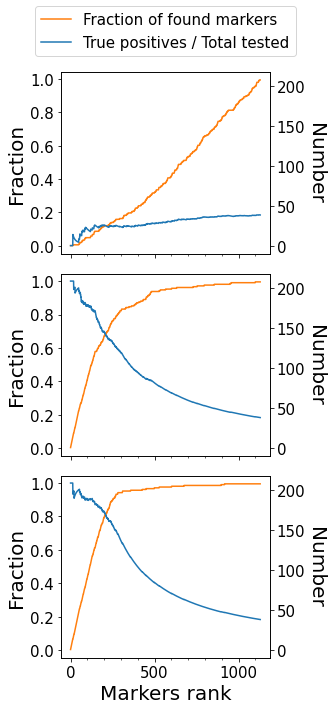

In [25]:
plot_tp('figures/ewing_markers.png',cc_genes_present,vars_bools)

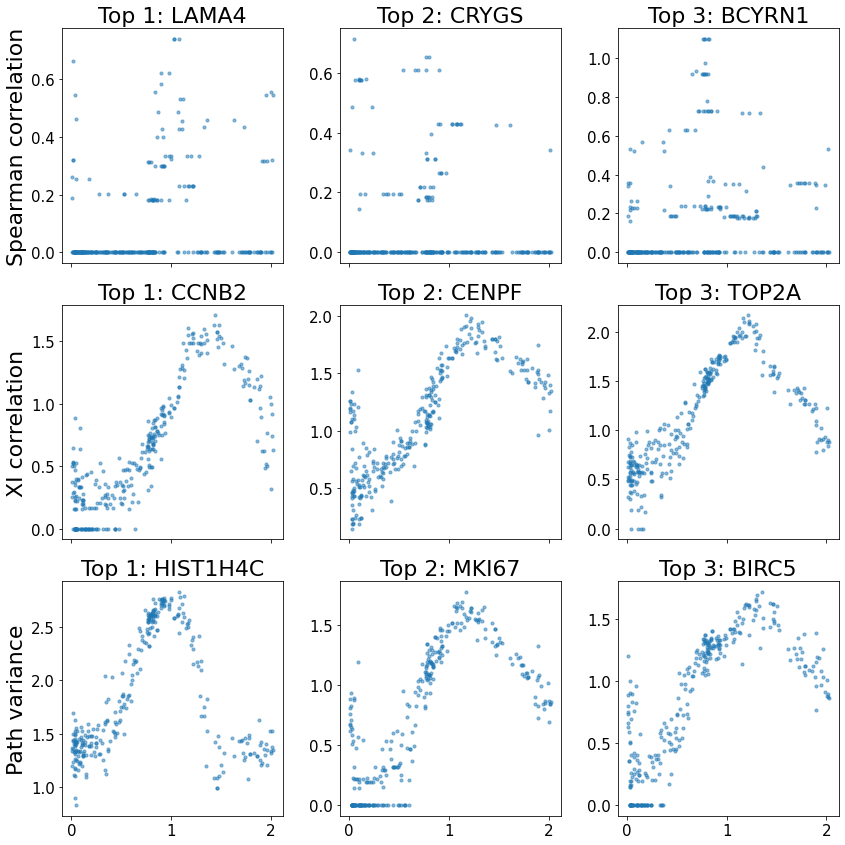

In [28]:
fig, ax = plt.subplots(3,3,figsize=(12,12),sharex=True)

corr = corr_spearman
for i,c in enumerate(corr.index[:3]):
    _c = _adata.var_names[_adata.var_names.map(lambda s:s.upper())==c.upper()][0]
    #ax[0,i].set_title(f'{_c}'+'='+str(round(corr[c],1)),fontsize=30)
    if i==0: ax[0,i].set_ylabel(f'Spearman correlation',fontsize=22)
    ax[0,i].set_title(f'Top '+str(i+1)+f': {_c}',fontsize=22)
    ax[0,i].scatter(_adata.obs['epg_pseudotime'],_adata[:,_c].X,s=10,alpha=.5)
    #ax[i,1].scatter(_adata.obsm['X_dr'][:,1],_adata.obsm['X_dr'][:,2],c=_adata[:,c].X)

corr = xicorr.sort_values(ascending=False)
for i,c in enumerate(corr.index[:3]):
    _c = _adata.var_names[_adata.var_names.map(lambda s:s.upper())==c.upper()][0]
    #ax[1,i].set_title(f'{_c}'+'='+str(round(corr[c],1)),fontsize=30)
    if i==0: ax[1,i].set_ylabel(f'XI correlation',fontsize=22)
    ax[1,i].set_title(f'Top '+str(i+1)+f': {_c}',fontsize=22)
    ax[1,i].scatter(_adata.obs['epg_pseudotime'],_adata[:,_c].X,s=10,alpha=.5)
    #ax[i,1].scatter(_adata.obsm['X_dr'][:,1],_adata.obsm['X_dr'][:,2],c=_adata[:,c].X)

corr = corr_var
for i,c in enumerate(corr.index[:3]):
    _c = _adata.var_names[_adata.var_names.map(lambda s:s.upper())==c.upper()][0]
    #ax[2,i].set_title(f'{_c}'+'='+str(round(corr[c],1)),fontsize=30)
    if i==0: ax[2,i].set_ylabel(f'Path variance',fontsize=22)
    ax[2,i].set_title(f'Top '+str(i+1)+f': {_c}',fontsize=22)
    ax[2,i].scatter(_adata.obs['epg_pseudotime'],_adata[:,_c].X,s=10,alpha=.5)
    #ax[i,1].scatter(_adata.obsm['X_dr'][:,1],_adata.obsm['X_dr'][:,2],c=_adata[:,c].X)

plt.tight_layout()
plt.savefig("figures/ewing_top3.png",dpi=300,bbox_inches="tight")
plt.show()

In [ ]:
marker=dict(opacity=data_scaled_to_values_between_0_and_1)

In [179]:
nodep=merged_nodep
edges=merged_edges

alpha=_anndata.obsm['X_dr'][:,2]
alpha=(alpha-alpha.min())/(alpha.max()-alpha.min())
alpha[alpha<.2]=.2

fig=px.scatter_3d(x=_anndata.obsm['X_dr'][:,0],y=_anndata.obsm['X_dr'][:,1],z=_anndata.obsm['X_dr'][:,2],
                  color=np.array(X_full['EWSR1']).astype(float),color_continuous_scale='Viridis_r')

fig.update_traces(marker=dict(size=2,opacity=.2))


for edge_i in edges:
    curve_i = np.concatenate((nodep[[edge_i[0]]], nodep[[edge_i[1]]]),axis=0).T
    fig.add_trace(go.Scatter3d(x=curve_i[0], 
                               y=curve_i[1], 
                               z=curve_i[2],
                               mode='lines',
                               line=dict(color='black', width=4))
                 )
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.8, y=-1., z=2)
)

fig.update_layout(height=900,width=1100,autosize=False,scene_camera=camera,
                  coloraxis_colorbar_title_text="Oncogene<br>EWSR1",
                  coloraxis_colorbar_len=.5,
                  coloraxis_colorbar_x=.7,
                  coloraxis_colorbar_title_font_size=25,
                  #legend=dict(itemsizing='constant',yanchor="top",y=0.5,xanchor="right",x=.95,font=dict(size=30),bgcolor='rgba(0,0,0,0)'),
                  margin=dict( l=0,r=0, b=0,t=0, pad=0),
                  scene_xaxis_tickvals = np.linspace(np.min(_anndata.obsm['X_dr'][:,0]),np.max(_anndata.obsm['X_dr'][:,0]),7), scene_xaxis_ticktext = ['']*7,
                  scene_yaxis_tickvals = np.linspace(np.min(_anndata.obsm['X_dr'][:,1]),np.max(_anndata.obsm['X_dr'][:,1]),7), scene_yaxis_ticktext = ['']*7,
                  scene_zaxis_tickvals = np.linspace(np.min(_anndata.obsm['X_dr'][:,2]),np.max(_anndata.obsm['X_dr'][:,2]),7), scene_zaxis_ticktext = ['']*7,
                  scene_xaxis_title_text='IC1 (G1/S)',scene_xaxis_title_font_size=30, 
                  scene_yaxis_title_text='IC2 (G2/M)',scene_yaxis_title_font_size=30,
                  scene_zaxis_title_text='IC10 (Oncogene level)',scene_zaxis_title_font_size=28,  
                  #paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')

for trace in fig['data']: 
    if(trace.mode!='markers'): trace['showlegend'] = False
fig.write_image('figures/ewing_.png',width=(8.3*.95)*300, height=(11.7/3)*300, scale=1,engine="kaleido")

In [52]:
_adata.obs=adata.obs
_adata.uns=adata.uns
_adata.obsm=adata.obsm

In [53]:
_adata=_adata[np.isfinite(_adata.obs['epg_pseudotime'])].copy()
_adata.uns['workdir']=''
st2.tl.detect_transition_markers(_adata,cutoff_spearman=0,cutoff_logfc=0.25,use_precomputed=False)

Scanning all features ...
Filtering out markers that are expressed in less than 5 cells ...
1 cpus are being used ...
1167 markers are being scanned ...


NameError: name 'merged_edges' is not defined

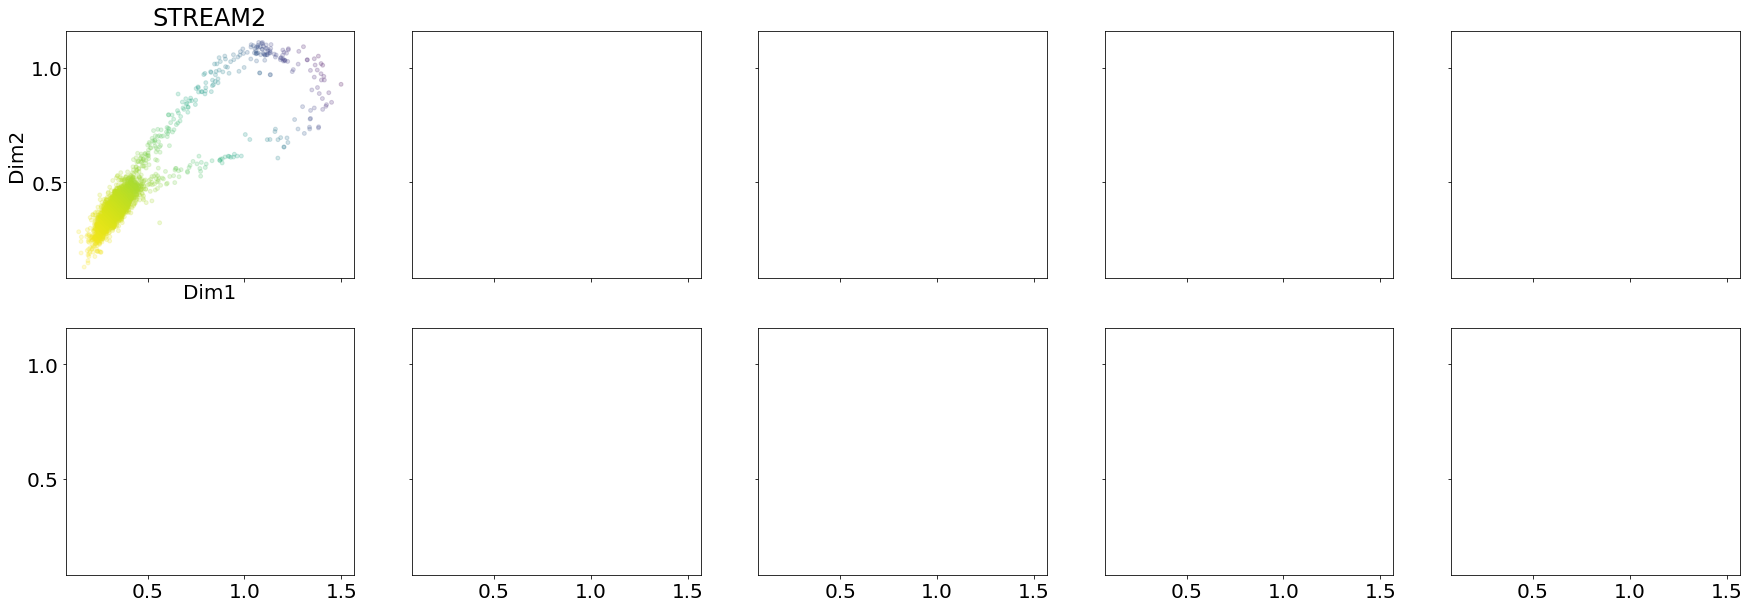

In [4]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(2,5,figsize=(30,10),sharey=True,sharex=True)
axs=axs.flat

X_plot=X
c_plot=c
linewidth=2

def init_subplot(d1=0,d2=2):
    ax = next(axs)
    ax.set_xlabel(f'Dim{d1+1}',labelpad=5)
    ax.set_ylabel(f'Dim{d2+1}',labelpad=5)
    ax.locator_params(axis='x',nbins=4)
    ax.locator_params(axis='y',nbins=4)
    ax.tick_params(axis="x",pad=10)
    ax.tick_params(axis="y",pad=-1)
    _=ax.scatter(X_plot[:,d1],X_plot[:,d2],c=c_plot,s=15,alpha=.2,cmap=plt.cm.viridis_r)
    return ax,_

for i0,(d1,d2) in enumerate(((0,1),(1,2))):

    #via
    ax,_=init_subplot(d1,d2)
    if i0==0: 
        ax.set_title('VIA')
        via_plot=via_out_ica
        (loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot)=(loci_pca, c_edge_ica, width_edge_ica,  pen_color_ica, dot_size_ica)
    else: 
        via_plot=via_out3_ica
        (loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot)=(loci3_ica, c_edge3_ica, width_edge3_ica, pen_color3_ica, dot_size3_ica)
    for i in range(len(via_plot)): 
        ax.plot(via_plot[i][0], via_plot[i][1], linewidth=linewidth, c='#323538')#1.5

        direction_arrow=via_plot[i][2]; head_width=via_plot[i][3]
        if direction_arrow == 1:
            ax.arrow(via_plot[i][4], via_plot[i][5], via_plot[i][6], via_plot[i][7], shape='full', lw=0, length_includes_head=False,
                      head_width=.03, color='#323538')  
    count_ = 0
    for i, c_e, w, pc, dsz in zip(loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot):  # sc_supercluster_nn
        ax.scatter(X[i, d1], X[i, d2], c='black', s=dsz, edgecolors=c_e, linewidth=w)
        count_ = count_ + 1

    #monocle
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('Monocle3')
    for e in mcle_edges:
        curve_i = np.concatenate((mcle_nodep[[e[0]]], mcle_nodep[[e[1]]]),axis=0).T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

    #slingshot
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('Slingshot')
    for l in slingshot_lineages['GMM']:
        curve_i = l.T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

    #paga
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('PAGA')
    for e,w in zip(paga_edges,paga_weights):
        curve_i = np.concatenate((paga_nodep[[e[0]]], paga_nodep[[e[1]]]),axis=0).T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=2*linewidth*w)

    #epg
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('STREAM2')
    for edge_i in merged_edges:
        curve_i = np.concatenate((merged_nodep[[edge_i[0]]], merged_nodep[[edge_i[1]]]),axis=0).T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)


fig.tight_layout()
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar=fig.colorbar(_, cax=cbar_ax)
cbar.set_label('Cell cycle score', rotation=270,labelpad=30)
cbar.set_alpha(1)
cbar.draw_all()
plt.savefig('figures/ewing_default_2d.png',dpi=300,bbox_inches='tight')

# Tuned

In [ ]:
# monocle, slingshot
for ncenters in (50,100,200):
    for mcle_sigma in (.0001,.001,.01,.1,1):
        for mcle_gamma in (.01,.1,.5,1,10):
            res_path='R_outputs/ewing/'
            print(ncenters,mcle_sigma,mcle_gamma)
            if f'_monocle_dp_mst_{ncenters}_{mcle_sigma}_{mcle_gamma}_.rds' in os.listdir(res_path):
                continue
            try:
                run_monocle_slingshot_tuned(data_path, res_path=res_path,
                                            slingshot_ncenters = ncenters, mcle_ncenters = ncenters, 
                                            mcle_sigma = mcle_sigma, mcle_gamma = mcle_gamma, mcle_eps = 1e-05)
            except:
                pass

50 1e-05 0.01

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citat

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_1e-04_1_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.0001 10
^C

Execution halted


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_1e-04_10_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.001 0.01
^C

Execution halted


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.001_0.01_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.001 0.1
100 0.001 0.5
^C

Execution halted


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.001_0.5_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.001 1

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor

In [1]:
import pickle
#paga, via, epg
all_via_out = {}
for knn in [15,20,30,50,100]:
    for dist_std_local in [1]:
        for jac_std_global in [.05,.1,.15,.3,.5,1]:
            if f'all_via_out_ewing_{knn}_{dist_std_local}_{jac_std_global}.pkl' in os.listdir('../results/'):
                continue
            ((via_out, via_projected_sc_pt, 
             (loci, c_edge, width_edge, pen_color, dot_size)),
             (via_out2, via_projected_sc_pt2,
             (loci2, c_edge2, width_edge2, pen_color2, dot_size2)),
             (via_out3, via_projected_sc_pt3,
             (loci3, c_edge3, width_edge3, pen_color3, dot_size3)))  = run_VIA(
                X,X,labels=None,  root_user = [0], v0_too_big = 0.3 , v1_too_big = 0.1, v0_random_seed = 42, 
                knn = knn,ncomps=3,jac_std_global=jac_std_global,dist_std_local=dist_std_local)
            all_via_out[(knn,dist_std_local,jac_std_global)]=[via_out, via_projected_sc_pt, (loci, c_edge, width_edge, pen_color, dot_size)]
            with open(f'../results/all_via_out_ewing_{knn}_{dist_std_local}_{jac_std_global}.pkl','wb') as f:
                pickle.dump([via_out, via_projected_sc_pt, (loci, c_edge, width_edge, pen_color, dot_size)],f)
            
with open('all_via_out_ewing.pkl','wb') as f:
    pickle.dump(all_via_out,f)
    
all_paga_out = {}
for resolution in [.1,.2,.5,1,1.2,1.5,2,3]:
    for knn in [15,20,30,50,100]:
        paga_nodep, paga_edges, paga_clus_points = run_paga(_anndata,X,resolution=resolution)
        all_paga_out[(knn,resolution)]=[paga_nodep, paga_edges, paga_clus_points]

with open('all_paga_out_ewing.pkl','wb') as f:
    pickle.dump(all_paga_out,f)

NameError: name 'dist_std_local' is not defined

In [5]:
import pickle
import os 

all_via_out_ica = {}
for knn in [15,20,30,50,100]:
    for dist_std_local in [1]:
        for jac_std_global in [.05,.1,.15,.3,.5,1]:
            print(f'all_via_out_ewing_ica_{knn}_{dist_std_local}_{jac_std_global}')
            if f'all_via_out_ewing_ica_{knn}_{dist_std_local}_{jac_std_global}.pkl' in os.listdir('../results/'):
                continue
            ((via_out, via_projected_sc_pt, 
             (loci, c_edge, width_edge, pen_color, dot_size)),
             (via_out2, via_projected_sc_pt2,
             (loci2, c_edge2, width_edge2, pen_color2, dot_size2)),
             (via_out3, via_projected_sc_pt3,
             (loci3, c_edge3, width_edge3, pen_color3, dot_size3)))  = run_VIA(
                _anndata.obsm['X_ica'],X,labels=None,  root_user = [0], v0_too_big = 0.3 , v1_too_big = 0.1, v0_random_seed = 42, 
                knn = knn,ncomps=20,jac_std_global=jac_std_global,dist_std_local=dist_std_local)
            all_via_out_ica[(knn,dist_std_local,jac_std_global)]=[via_out, via_projected_sc_pt, (loci, c_edge, width_edge, pen_color, dot_size)]
            with open(f'../results/all_via_out_ewing_ica_{knn}_{dist_std_local}_{jac_std_global}.pkl','wb') as f:
                pickle.dump([via_out, via_projected_sc_pt, (loci, c_edge, width_edge, pen_color, dot_size)],f)

all_via_out_ewing_ica_15_1_0.05
all_via_out_ewing_ica_15_1_0.1
all_via_out_ewing_ica_15_1_0.15
all_via_out_ewing_ica_15_1_0.3
all_via_out_ewing_ica_15_1_0.5
all_via_out_ewing_ica_15_1_1
all_via_out_ewing_ica_20_1_0.05
all_via_out_ewing_ica_20_1_0.1
all_via_out_ewing_ica_20_1_0.15
all_via_out_ewing_ica_20_1_0.3
all_via_out_ewing_ica_20_1_0.5
all_via_out_ewing_ica_20_1_1
all_via_out_ewing_ica_30_1_0.05
all_via_out_ewing_ica_30_1_0.1
all_via_out_ewing_ica_30_1_0.15
all_via_out_ewing_ica_30_1_0.3
all_via_out_ewing_ica_30_1_0.5
all_via_out_ewing_ica_30_1_1
all_via_out_ewing_ica_50_1_0.05
all_via_out_ewing_ica_50_1_0.1
all_via_out_ewing_ica_50_1_0.15
all_via_out_ewing_ica_50_1_0.3
all_via_out_ewing_ica_50_1_0.5
all_via_out_ewing_ica_50_1_1
all_via_out_ewing_ica_100_1_0.05
all_via_out_ewing_ica_100_1_0.1
all_via_out_ewing_ica_100_1_0.15
all_via_out_ewing_ica_100_1_0.3
all_via_out_ewing_ica_100_1_0.5
all_via_out_ewing_ica_100_1_1


In [15]:
# monocle, slingshot
res_path='R_outputs/ewing/'
for ncenters in (50,100,200):
    for mcle_sigma in (.00001,.0001,.001,.01,.1,1):
        for mcle_gamma in (.01,.1,.5,1,10):
            print(ncenters,mcle_sigma,mcle_gamma)
            #if f'ewing_{ncenters}_{mcle_sigma}_{mcle_gamma}_2d.png' in os.listdir('figures/'):
            #    continue
            try:
                slingshot_lineages = load_slingshot(res_path,ncenters)
                mcle_nodep, mcle_stree, mcle_edges, mcle_partitions, mcle_clusters = load_monocle(res_path, ncenters, mcle_sigma, mcle_gamma)
            except:
                continue
                
            plt.rcParams.update({'font.size': 20})
            fig, axs = plt.subplots(2,5,figsize=(30,10),sharey=True,sharex=True)
            axs=axs.flat
            X_plot=X
            c_plot=c
            linewidth=2

            def init_subplot(d1=0,d2=2):
                ax = next(axs)
                ax.set_xlabel(f'Dim{d1+1}',labelpad=5)
                ax.set_ylabel(f'Dim{d2+1}',labelpad=5)
                ax.locator_params(axis='x',nbins=4)
                ax.locator_params(axis='y',nbins=4)
                ax.tick_params(axis="x",pad=10)
                ax.tick_params(axis="y",pad=-1)
                _=ax.scatter(X_plot[:,d1],X_plot[:,d2],c=c_plot,s=15,alpha=.2)
                return ax,_

            for i0,(d1,d2) in enumerate(((0,1),(1,2))):

                #via
                ax,_=init_subplot(d1,d2)
                if i0==0: 
                    ax.set_title('VIA')
                    via_plot=via_out
                    (loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot)=(loci, c_edge, width_edge,  pen_color, dot_size)
                else: 
                    via_plot=via_out3
                    (loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot)=(loci3, c_edge3, width_edge3, pen_color3, dot_size3)
                for i in range(len(via_out)): 
                    ax.plot(via_plot[i][0], via_plot[i][1], linewidth=linewidth, c='#323538')#1.5

                    direction_arrow=via_plot[i][2]; head_width=via_out[i][3]
                    if direction_arrow == 1:
                        ax.arrow(via_plot[i][4], via_plot[i][5], via_plot[i][6], via_plot[i][7], shape='full', lw=0, length_includes_head=False,
                                  head_width=.03, color='#323538')  
                count_ = 0
                for i, c_e, w, pc, dsz in zip(loci, c_edge, width_edge, pen_color, dot_size):  # sc_supercluster_nn
                    ax.scatter(X[i, d1], X[i, d2], c='black', s=dsz, edgecolors=c_e, linewidth=w)
                    count_ = count_ + 1

                #monocle
                ax,_=init_subplot(d1,d2)
                if i0==0: ax.set_title('Monocle3')
                for e in mcle_edges:
                    curve_i = np.concatenate((mcle_nodep[[e[0]]], mcle_nodep[[e[1]]]),axis=0).T
                    ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

                #slingshot
                ax,_=init_subplot(d1,d2)
                if i0==0: ax.set_title('Slingshot')
                for l in slingshot_lineages['kmeans']:
                    curve_i = l.T
                    ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

                #paga
                ax,_=init_subplot(d1,d2)
                if i0==0: ax.set_title('PAGA')
                for e,w in zip(paga_edges,paga_weights):
                    curve_i = np.concatenate((paga_nodep[[e[0]]], paga_nodep[[e[1]]]),axis=0).T
                    ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=2*linewidth*w)

                #epg
                ax,_=init_subplot(d1,d2)
                if i0==0: ax.set_title('STREAM2')
                for edge_i in merged_edges:
                    curve_i = np.concatenate((merged_nodep[[edge_i[0]]], merged_nodep[[edge_i[1]]]),axis=0).T
                    ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)
                    
            fig.tight_layout()
            fig.subplots_adjust(right=0.82)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
            cbar=fig.colorbar(_, cax=cbar_ax)
            cbar.set_label('Cell cycle score', rotation=270,labelpad=30)
            cbar.set_alpha(1)
            cbar.draw_all()
            plt.savefig(f'figures/ewing_{ncenters}_{mcle_sigma}_{mcle_gamma}_2d.png',dpi=300,bbox_inches='tight')
            plt.close()

50 1e-05 0.01
50 1e-05 0.1
50 1e-05 0.5
50 1e-05 1
50 1e-05 10
50 0.0001 0.01
50 0.0001 0.1
50 0.0001 0.5
50 0.0001 1
50 0.0001 10
50 0.001 0.01
50 0.001 0.1
50 0.001 0.5
50 0.001 1
50 0.001 10
50 0.01 0.01
50 0.01 0.1
50 0.01 0.5
50 0.01 1
50 0.01 10
50 0.1 0.01
50 0.1 0.1
50 0.1 0.5
50 0.1 1
50 0.1 10
50 1 0.01
50 1 0.1
50 1 0.5
50 1 1
50 1 10
100 1e-05 0.01
100 1e-05 0.1
100 1e-05 0.5
100 1e-05 1
100 1e-05 10
100 0.0001 0.01
100 0.0001 0.1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_1e-04_0.5_.rds', probable reason 'No such file or directory'



100 0.0001 0.5

Error in gzfile(file, "rb") : cannot open the connection
100 0.0001 1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_1e-04_1_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_1e-04_10_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.0001 10

Error in gzfile(file, "rb") : cannot open the connection
100 0.001 0.01


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.001_0.01_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.001_0.1_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.001 0.1

Error in gzfile(file, "rb") : cannot open the connection
100 0.001 0.5


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.001_0.5_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.001_1_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.001 1

Error in gzfile(file, "rb") : cannot open the connection
100 0.001 10


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.001_10_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.01_0.01_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.01 0.01

Error in gzfile(file, "rb") : cannot open the connection
100 0.01 0.1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.01_0.1_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.01_0.5_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.01 0.5

Error in gzfile(file, "rb") : cannot open the connection
100 0.01 1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.01_1_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.01_10_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.01 10

Error in gzfile(file, "rb") : cannot open the connection
100 0.1 0.01


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.1_0.01_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.1_0.1_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.1 0.1

Error in gzfile(file, "rb") : cannot open the connection
100 0.1 0.5


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.1_0.5_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.1_1_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 0.1 1

Error in gzfile(file, "rb") : cannot open the connection
100 0.1 10


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_0.1_10_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_1_0.01_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 1 0.01

Error in gzfile(file, "rb") : cannot open the connection
100 1 0.1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_1_0.1_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_1_0.5_.rds', probable reason 'No such file or directory'




Error in gzfile(file, "rb") : cannot open the connection
100 1 0.5

Error in gzfile(file, "rb") : cannot open the connection
100 1 1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_1_1_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_monocle_dp_mst_100_1_10_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed fi


Error in gzfile(file, "rb") : cannot open the connection
100 1 10

Error in gzfile(file, "rb") : cannot open the connection
200 1e-05 0.01

Error in gzfile(file, "rb") : cannot open the connection


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed 


Error in gzfile(file, "rb") : cannot open the connection
200 1e-05 0.1

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 1e-05 0.5

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 1e-05 1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed 


Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 1e-05 10

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.0001 0.01

Error in gzfile(file, "rb") : cannot open the connection


R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console


Error in gzfile(file, "rb") : cannot open the connection
200 0.0001 0.1

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.0001 0.5

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.0001 1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed 


Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.0001 10

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.001 0.01

Error in gzfile(file, "rb") : cannot open the connection


R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console


Error in gzfile(file, "rb") : cannot open the connection
200 0.001 0.1

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.001 0.5

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.001 1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed 


Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.001 10

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.01 0.01

Error in gzfile(file, "rb") : cannot open the connection


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed 


Error in gzfile(file, "rb") : cannot open the connection
200 0.01 0.1

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.01 0.5

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.01 1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed 


Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.01 10

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.1 0.01

Error in gzfile(file, "rb") : cannot open the connection


R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In


Error in gzfile(file, "rb") : cannot open the connection
200 0.1 0.1

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.1 0.5

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.1 1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed 


Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 0.1 10

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 1 0.01

Error in gzfile(file, "rb") : cannot open the connection


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed 


Error in gzfile(file, "rb") : cannot open the connection
200 1 0.1

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 1 0.5

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 1 1


R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_curves_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'R_outputs/ewing/_slingshot_kmeans_200_.rds', probable reason 'No such file or directory'

R[write to console]: Error in gzfile(file, "rb") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  cannot open compressed 


Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection
200 1 10

Error in gzfile(file, "rb") : cannot open the connection

Error in gzfile(file, "rb") : cannot open the connection


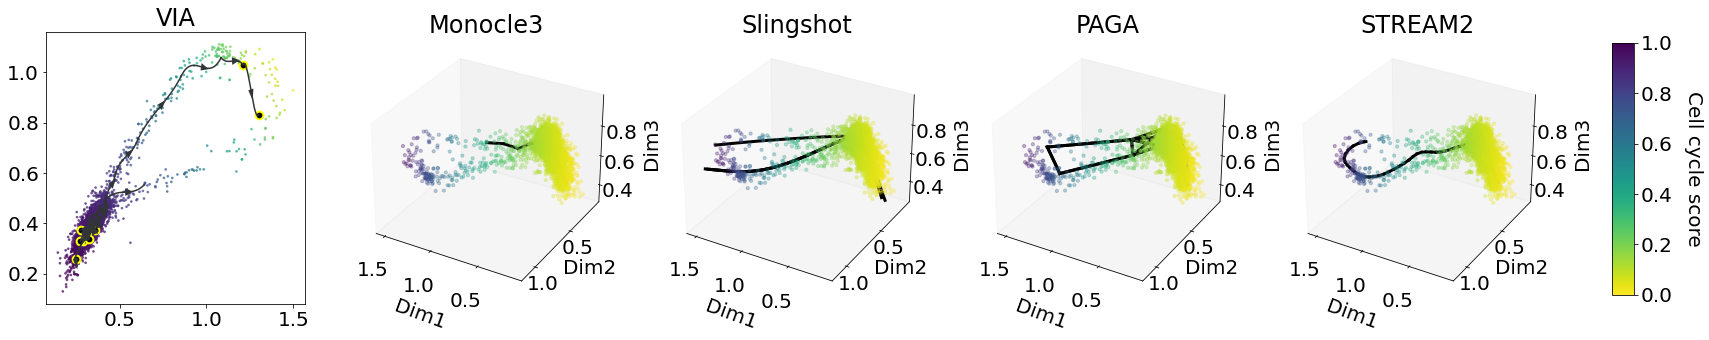

In [239]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(30,5))

#remove some points in dense region to make graphs visible
idx=np.random.choice(np.where(X[:,2]>.5)[0],1000,replace=False)
X_plot=X#[idx]
c_plot=c#[idx]

def init_subplot(num):
    ax = fig.add_subplot(num, projection='3d')
    ax.view_init(azim=120)
    #ax.xaxis.pane.fill = False
    #ax.yaxis.pane.fill = False
    #ax.zaxis.pane.fill = False
    #ax.xaxis.pane.set_color('lightgrey')
    #ax.yaxis.pane.set_color('lightgrey')
    #ax.zaxis.pane.set_color('lightgrey')
    ax.set_xlabel('Dim1',labelpad=20,rotation=-20)
    ax.set_ylabel('Dim2',labelpad=5,rotation=0)
    ax.set_zlabel('Dim3',labelpad=10,rotation=90)
    ax.locator_params(axis='x',nbins=4)
    ax.locator_params(axis='y',nbins=4)
    ax.locator_params(axis='z',nbins=4)
    ax.tick_params(axis="x",pad=10)
    ax.tick_params(axis="y",pad=-1)
    ax.tick_params(axis="z",pad=3.5)
    ax.grid(False)
    _=ax.scatter(X_plot[:,0],X_plot[:,1],X_plot[:,2],c=c_plot,s=10,alpha=.3,cmap=plt.cm.viridis_r)
    return ax,_

#via
ax=fig.add_subplot(151)
ax.scatter(X[:,0],X[:,1],c=c, alpha=0.6, s=3)
ax.set_title('VIA')
for i in range(len(via_out)): 
    ax.plot(via_out[i][0], via_out[i][1], linewidth=1.5, c='#323538')#1.5

    direction_arrow=via_out[i][2]; head_width=via_out[i][3]
    if direction_arrow == 1:
        ax.arrow(via_out[i][4], via_out[i][5], via_out[i][6], via_out[i][7], shape='full', lw=0, length_includes_head=False,
                  head_width=.03, color='#323538')  
count_ = 0
for i, c_e, w, pc, dsz in zip(loci, c_edge, width_edge, pen_color, dot_size):  # sc_supercluster_nn
    ax.scatter(X[i, 0], X[i, 1], c='black', s=dsz, edgecolors=c_e, linewidth=w)
    count_ = count_ + 1
    
#monocle
ax,_=init_subplot(152)
ax.set_title('Monocle3')
for e in mcle_edges:
    curve_i = np.concatenate((mcle_nodep[[e[0]]], mcle_nodep[[e[1]]]),axis=0).T
    ax.plot(curve_i[0], curve_i[1], curve_i[2], c='k',linewidth=3)

#slingshot
ax,_=init_subplot(153)
ax.set_title('Slingshot')
for l in slingshot_lineages['GMM']:
    curve_i = l.T
    ax.plot(curve_i[0], curve_i[1], curve_i[2], c='k',linewidth=3)

#paga
ax,_=init_subplot(154)
ax.set_title('PAGA')
for e in paga_edges:
    curve_i = np.concatenate((paga_nodep[[e[0]]], paga_nodep[[e[1]]]),axis=0).T
    ax.plot(curve_i[0], curve_i[1], curve_i[2], c='k',linewidth=3)

#epg
ax,_=init_subplot(155)
ax.set_title('STREAM2')
for edge_i in epg_edges:
    curve_i = np.concatenate((epg_nodep[[edge_i[0]]], epg_nodep[[edge_i[1]]]),axis=0).T
    ax.plot(curve_i[0], curve_i[1], curve_i[2], c='k',linewidth=3)

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar=fig.colorbar(_, cax=cbar_ax)
cbar.set_label('Cell cycle score', rotation=270,labelpad=30)
cbar.set_alpha(1)
cbar.draw_all()
plt.savefig('figures/ewing_tuned.png',dpi=300,bbox_inches='tight')